# ELO Final Data Wrangling and Model Building

## 0. Import all modules

In [1]:
#Import all modules

#data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random
import datetime

#visulalization
%matplotlib inline
import matplotlib.pyplot as plt
#from IPython.display import image

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import partial_dependence
from sklearn.preprocessing import LabelEncoder

#import xgboost as xgb
#from xgboost import XGBClassifier
#from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
#from pygam import LogisticGAM

#cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats as stats

#parallel processing
from joblib import Parallel, delayed
import multiprocessing
cpus=multiprocessing.cpu_count()

#Import the garbage collection module
import gc   #gc.collect -> Manual garbage collection
import time

#Set maximum number of rows,columns to be shown. Maximum column width made to 500.
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

In [2]:
import os
os.chdir("C:\Master\PD_Career\Courses\Springboard\ELO Merchant Category Recommendation")

#data directory
data_path = "datasets/"
intermediate_data_path = "datasets/intermediate/"
source_data_path = "datasets/source/"
submit_data_path = "datasets/submit/"

# Common Functions used across datasets

In [3]:
def one_hot_encoding(df,col):
    one_hot=pd.get_dummies(df[col],drop_first=True)
    one_hot.columns=[col+'_'+ str(element) for element in one_hot.columns.values ]
    df = df.join(one_hot)
    df = df.drop(col,axis=1)
    return df

In [4]:
def transform_train_test(dataset):
    dataset['elapsed_active_days'] = (datetime.date(2018, 2, 1) - dataset['first_active_month'].dt.date).dt.days
    categorical_features = ['feature_1', 'feature_2', 'feature_3']
    for col in categorical_features:
        dataset=one_hot_encoding(dataset,col)
    return dataset

In [5]:
def transform_train_hist_tran(dataset):
    # Convert the binary variables to 0, 1 format
    dataset['authorized_flag']=dataset['authorized_flag'].map({'Y':1,'N':0})
    dataset['category_1']=dataset['category_1'].map({'Y':1,'N':0})
    dataset['purchase_elapsed_days'] = (datetime.date(2018, 2, 1) - dataset['purchase_date'].dt.date).dt.days
    dataset['category_2'].fillna(dataset['category_2'].median(),inplace=True)
    dataset['category_2']=dataset['category_2'].astype(int)
    dataset=one_hot_encoding(dataset,'category_2')
    #dataset.drop('category_2_5',axis=1,inplace=True)
    
    # Replace the null in category_3 with the value 'A' (the value with highest frequency)
    dataset['category_3'].fillna('A',inplace=True)
    dataset=one_hot_encoding(dataset,'category_3')
    # dataset.drop('category_3_C',axis=1,inplace=True)
    # Delete the date fields as we already derived the elapsed days from them
    del dataset['first_active_month']
    del dataset['purchase_date']
    return dataset

In [6]:
def aggregate_history(history):
    
   
    agg_func = {
        'authorized_flag': ['sum', 'mean', 'median'],
        'category_1_x': ['sum', 'mean', 'median'],
        'category_2_2_x': ['sum','mean', 'median'],
        'category_2_3_x': ['sum','mean', 'median'],
        'category_2_4_x': ['sum','mean', 'median'],
        'category_2_5_x': ['sum','mean', 'median'],        
        'category_3_B': ['sum'],
        'category_3_C': ['sum'],
        'city_id_x': ['nunique'],
        'city_id_69':['sum'],
        'city_id_neg_1':['sum'],
        'city_id_333':['sum'],
        'installments': [np.ptp,'sum', 'max', 'min', 'mean', 'median'],
        'merchant_category_id_x': ['nunique'],
        'merchant_group_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': [np.ptp, 'sum', 'min', 'max', 'mean', 'median'],
        'purchase_amount': [np.ptp, 'sum', 'max', 'min', 'mean', 'median'],
        'state_id_x': ['nunique'],
        'subsector_id_x': ['nunique'],
        'purchase_elapsed_days':[np.ptp,'sum', 'median', 'max', 'min', 'mean'],
        'numerical_1': [np.ptp, 'sum','max','min', 'mean', 'median'],
        'avg_sales_lag3': ['sum','mean', 'median'],
        'avg_sales_lag6': ['sum','mean', 'median'],
        'avg_sales_lag12': ['sum','mean', 'median'],
        'avg_purchases_lag3': ['sum','mean', 'median'],
        'avg_purchases_lag6': ['sum','mean', 'median'],  
        'avg_purchases_lag12': ['sum','mean', 'median'],
        'category_4':['sum'],
        'numerical_1_low':['sum']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id').size().reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [7]:
def aggregate_new_merchant(new_merchants_dataset):
    
    agg_func = {
        'authorized_flag': ['sum', 'mean', 'median'],
        'category_1_x': ['sum', 'mean', 'median'],
        'category_2_2_x': ['sum','mean', 'median'],
        'category_2_3_x': ['sum','mean', 'median'],
        'category_2_4_x': ['sum','mean', 'median'],
        'category_2_5_x': ['sum','mean', 'median'],        
        'category_3_B': ['sum'],
        'category_3_C': ['sum'],
        'city_id_x': ['nunique'],
        'city_id_69':['sum'],
        'city_id_neg_1':['sum'],
        'city_id_333':['sum'],
        'installments': [np.ptp,'sum', 'max', 'min', 'mean', 'median'],
        'merchant_category_id_x': ['nunique'],
        'merchant_group_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': [np.ptp, 'sum', 'min', 'max', 'mean', 'median'],
        'purchase_amount': [np.ptp, 'sum', 'max', 'min', 'mean', 'median'],
        'state_id_x': ['nunique'],
        'subsector_id_x': ['nunique'],
        'purchase_elapsed_days':[np.ptp,'sum', 'median', 'max', 'min', 'mean'],
        'numerical_1': [np.ptp, 'sum','max','min', 'mean', 'median'],
        'avg_sales_lag3': ['sum','mean', 'median'],
        'avg_sales_lag6': ['sum','mean', 'median'],
        'avg_sales_lag12': ['sum','mean', 'median'],
        'avg_purchases_lag3': ['sum','mean', 'median'],
        'avg_purchases_lag6': ['sum','mean', 'median'],  
        'avg_purchases_lag12': ['sum','mean', 'median'],
        'category_4':['sum'],
        'numerical_1_low':['sum']
        }
    agg_new_merchants_dataset = new_merchants_dataset.groupby(['card_id']).agg(agg_func)
    agg_new_merchants_dataset.columns = ['new_mer_' + '_'.join(col).strip() for col in agg_new_merchants_dataset.columns.values]
    agg_new_merchants_dataset.reset_index(inplace=True)
    
    df = (new_merchants_dataset.groupby('card_id').size().reset_index(name='new_mer_transactions_count'))
    
    agg_new_merchants_dataset = pd.merge(df, agg_new_merchants_dataset, on='card_id', how='left')
    
    return agg_new_merchants_dataset

## Creation of Kaggle Submission File
We create a submission file to assess where the solution stands on public/private leaderboard.

In [9]:
# id_test and target score are two lists
def create_submit_file(name, test_id_list, test_target_score):
    submission=pd.DataFrame()
    submission['card_id']=test_id_list
    submission['target']=test_target_score
    # display(submission.head(5))
    submission.to_csv(submit_data_path + name, index=False)
    del submission

## 1. Data Import, Cleaning and Wrangling

In [10]:
#Import train data
train=pd.read_csv(data_path+"train.csv",parse_dates=['first_active_month'])
print(train.shape)
display(train.info())
display(train.head(5))
#Transform the training dataset
train = transform_train_test(train)
display(train.head(5))

(201917, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


None

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1
0,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1
1,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0
2,2016-08-01,C_ID_d639edf6cd,0.688056,549,1,0,0,0,1,0,0
3,2017-09-01,C_ID_186d6a6901,0.142495,153,0,0,1,0,0,1,0
4,2017-11-01,C_ID_cdbd2c0db2,-0.159749,92,0,0,0,0,0,1,0


In [11]:
#Import historical transactions
historical_transactions=pd.read_csv(data_path+'historical_transactions.csv',parse_dates=['purchase_date'])
display(historical_transactions.shape)
display(historical_transactions.head(5)) #Preview historical_trasactions data
display(historical_transactions.info())
#display(historical_transactions.describe())

(29112361, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 3.0+ GB


None

<b>Dealing with Large Datasets</b> <br>
1. The historical transactions dataset has 29.1 million transactions. Each row in historical transactions dataset has 14 columns. <br>
2. Because of sheer volume of historical transactions dataset, we will divide the dataset into 3 parts 
based on target value in training dataset (low, medium and high). Before this operation, we will also 
separate the training outliers dataset. <br>
3. This code segment needs to run only once to divide the historical transactions dataset and aggregate them together (training dataset, historical transactions, merchants etc) <br>
4. The subsequent modeling activity can take these intermediate datasets as source in order to save the time and resources used for computing this step.

In [13]:
# # We decide to separate the extreme outliers from the training dataset and keep them separately.
# train_outliers = train[train['target']<-30]
# train_rem = train[train['target']>=-30]

In [14]:
# # Dividing train_rem into 3 datasets based on target score

# target_low_lower_limit=np.percentile(train_rem['target'],0)
# target_low_upper_limit=np.percentile(train_rem['target'],33.3)
# target_med_upper_limit=np.percentile(train_rem['target'],66.6)
# display((target_low_lower_limit, target_low_upper_limit,target_med_upper_limit))

# def target_range (row,low,high):
#     if row['target'] >= low and row['target'] < high:
#         return 1
#     else:
#         return 0


# train_rem['target_low'] = 0
# train_rem['target_med'] = 0

# train_rem['target_low']= train.apply(lambda row: target_range(row,target_low_lower_limit,target_low_upper_limit),axis=1)
# train_rem['target_med']= train.apply(lambda row: target_range(row,target_low_upper_limit,target_med_upper_limit),axis=1)

# display(sum(train_rem['target_low']))
# display(sum(train_rem['target_med']))

(-17.60814651, -0.5096408724, 0.45557336553999994)

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

66504

66503

Next, We divide the training dataset and storing the fragmented training dataset in source folder.

In [17]:
# train_low_target=train_rem[train_rem['target_low']==1]
# train_med_target=train_rem[train_rem['target_med']==1]
# train_high_target=train_rem[(train_rem['target_low']==0) & (train_rem['target_med']==0)]

# #Saving the intermediate training datasets
# train_low_target.to_csv(source_data_path+'train_low_target.csv',index=False)
# train_med_target.to_csv(source_data_path+'train_med_target.csv',index=False)
# train_high_target.to_csv(source_data_path+'train_high_target.csv',index=False)
# train_outliers.to_csv(source_data_path+'train_outliers.csv',index=False)

# # Garbage collection
# gc.collect()

60

Next, We split of Historical Transactions Dataset based on Target Score (Outliers, Low, Medium, High) <br>

In [18]:
# # Divide the historical transactions into 3 parts based on target score (joined by card_id)

# hist_tran_outliers=pd.merge(train_outliers, historical_transactions, on='card_id', how='left')
# hist_tran_outliers.to_csv(source_data_path+'hist_tran_outliers.csv',index=False)
# del hist_tran_outliers

# hist_tran_low_target=pd.merge(train_low_target, historical_transactions, on='card_id', how='left')
# hist_tran_low_target.to_csv(source_data_path+'hist_tran_low_target.csv',index=False)
# del hist_tran_low_target

# gc.collect()

# hist_tran_med_target=pd.merge(train_med_target,historical_transactions, on='card_id', how='left')
# hist_tran_med_target.to_csv(source_data_path+'hist_tran_med_target.csv',index=False)
# del hist_tran_med_target

# hist_tran_high_target=pd.merge(train_high_target,historical_transactions, on='card_id', how='left')
# hist_tran_high_target.to_csv(source_data_path+'hist_tran_high_target.csv',index=False)
# del hist_tran_high_target
# del historical_transactions
# gc.collect()

49

## Merchants dataset
Now we will load the merchants dataset, transform it and keep it ready for joining to the combined 
dataset of training and historical transactions. <br>

In [27]:
# Import the Merchants Dataset and create features
merchants=pd.read_csv(data_path+"merchants.csv")
print(merchants.shape)
display(merchants.head(5))
display(merchants.isna().sum())

(334696, 22)


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [20]:
# Functions for Data wrangling of Merchants dataset

# Used for city_id field
def city_derivation (row,col, value):
    if row[col] == value:
        return 1
    else:
        return 0

# Used for numerical_1 field
def numerical_range (row,value):
    if row['numerical_1'] <= value:
        return 1
    else:
        return 0

In [26]:
# Functions for Data wrangling of Merchants dataset

def transform_merchants(dataset):
    dataset=dataset.dropna(subset=['avg_sales_lag3','avg_sales_lag6', 'avg_sales_lag12'])
    # Apply one hot encoding and drop the original columns and column related to one element.
    dataset=one_hot_encoding(dataset,'most_recent_sales_range')
    dataset=one_hot_encoding(dataset,'most_recent_purchases_range')
    
    # Dropping numerical_2 column as it is highly correlated to numerical_1.  
    dataset.drop('numerical_2',axis=1,inplace=True)

    # Transform the category fields appropriately.
    dataset['category_1'] = dataset['category_1'].map({'Y':1, 'N':0})
    dataset['category_4'] = dataset['category_4'].map({'Y':1, 'N':0})
    
    # Replacing the field category_2 by median. Then One Hot Encoding
    dataset['category_2'].fillna(dataset['category_2'].median(),inplace=True)
    dataset['category_2']=dataset['category_2'].astype(int)
    dataset=one_hot_encoding(dataset,'category_2')
    
    # As the numerical_1 column has value -0.057470 for more than 50% of records, An indicator was added.
    dataset['numerical_1_low']=dataset.apply(lambda row: numerical_range(row,-0.057470),axis=1)
    
    # Transform the city_id variable and create separate indicators for few cities 
    # with high transactions and purchase amounts
    dataset['city_id_69']=0
    dataset['city_id_neg_1']=0
    dataset['city_id_333']=0

    dataset['city_id_69']=dataset.apply(lambda row: city_derivation(row,'city_id',69),axis=1)
    dataset['city_id_neg_1']=dataset.apply(lambda row: city_derivation(row,'city_id',-1),axis=1)
    dataset['city_id_333']=dataset.apply(lambda row: city_derivation(row,'city_id',333),axis=1)
  
  
    return dataset

In [28]:
display(merchants.head(5))
merchants = transform_merchants(merchants)
display(merchants.head(5))
# Save the intermediate merchants dataset
merchants.to_csv(intermediate_data_path+'merchants_transformed.csv',index=False)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,category_1,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,most_recent_sales_range_B,most_recent_sales_range_C,most_recent_sales_range_D,most_recent_sales_range_E,most_recent_purchases_range_B,most_recent_purchases_range_C,most_recent_purchases_range_D,most_recent_purchases_range_E,category_2_2,category_2_3,category_2_4,category_2_5,numerical_1_low,city_id_69,city_id_neg_1,city_id_333
0,M_ID_838061e48c,8353,792,9,-0.057471,0,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,0,242,9,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,M_ID_9339d880ad,3184,840,20,-0.057471,0,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,0,22,16,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,M_ID_e726bbae1e,447,690,1,-0.057471,0,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,0,-1,5,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0
16,M_ID_c929bb59af,9514,2,20,-0.057471,0,69667.00,1.000000,3,69667.00,1.000000,3,69667.00,1.000000,3,0,-1,20,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0
17,M_ID_dd3ae3de10,30534,278,37,-0.057471,0,5180.00,4.000000,3,9830.00,4.166667,6,15826.00,5.600000,10,1,11,23,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0


In [8]:
# Load the merchants dataset if not loaded
# merchants=pd.read_csv(intermediate_data_path+"merchants_transformed.csv")

# Ensure there are no null values in merchants transformed dataset.
display(merchants.shape)
display(merchants.head(5))
display(merchants.info())
#display(merchants.describe())
display(merchants.isna().sum())

(334683, 34)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,category_1,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,most_recent_sales_range_B,most_recent_sales_range_C,most_recent_sales_range_D,most_recent_sales_range_E,most_recent_purchases_range_B,most_recent_purchases_range_C,most_recent_purchases_range_D,most_recent_purchases_range_E,category_2_2,category_2_3,category_2_4,category_2_5,numerical_1_low,city_id_69,city_id_neg_1,city_id_333
0,M_ID_838061e48c,8353,792,9,-0.057471,0,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,0,242,9,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,M_ID_9339d880ad,3184,840,20,-0.057471,0,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,0,22,16,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,M_ID_e726bbae1e,447,690,1,-0.057471,0,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,0,-1,5,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0
3,M_ID_c929bb59af,9514,2,20,-0.057471,0,69667.00,1.000000,3,69667.00,1.000000,3,69667.00,1.000000,3,0,-1,20,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0
4,M_ID_dd3ae3de10,30534,278,37,-0.057471,0,5180.00,4.000000,3,9830.00,4.166667,6,15826.00,5.600000,10,1,11,23,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334683 entries, 0 to 334682
Data columns (total 34 columns):
merchant_id                      334683 non-null object
merchant_group_id                334683 non-null int64
merchant_category_id             334683 non-null int64
subsector_id                     334683 non-null int64
numerical_1                      334683 non-null float64
category_1                       334683 non-null int64
avg_sales_lag3                   334683 non-null float64
avg_purchases_lag3               334683 non-null float64
active_months_lag3               334683 non-null int64
avg_sales_lag6                   334683 non-null float64
avg_purchases_lag6               334683 non-null float64
active_months_lag6               334683 non-null int64
avg_sales_lag12                  334683 non-null float64
avg_purchases_lag12              334683 non-null float64
active_months_lag12              334683 non-null int64
category_4                       334683 non-null 

None

merchant_id                      0
merchant_group_id                0
merchant_category_id             0
subsector_id                     0
numerical_1                      0
category_1                       0
avg_sales_lag3                   0
avg_purchases_lag3               0
active_months_lag3               0
avg_sales_lag6                   0
avg_purchases_lag6               0
active_months_lag6               0
avg_sales_lag12                  0
avg_purchases_lag12              0
active_months_lag12              0
category_4                       0
city_id                          0
state_id                         0
most_recent_sales_range_B        0
most_recent_sales_range_C        0
most_recent_sales_range_D        0
most_recent_sales_range_E        0
most_recent_purchases_range_B    0
most_recent_purchases_range_C    0
most_recent_purchases_range_D    0
most_recent_purchases_range_E    0
category_2_2                     0
category_2_3                     0
category_2_4        

## Historical Transactions Dataset Aggregation
1. Combining Training dataset, historical transactions and merchants dataset. <br>
2. Aggregation at card_id. <br>
3. Repeat the steps for all parts of transactions dataset (low-med-high-outliers target score). <br>

## Function to transform and aggregate historical transactions dataset 

In [26]:
def transform_agg_hist_tran(dataset):
    dataset_2=transform_train_hist_tran(dataset)
    del dataset
    gc.collect()
    dataset_2_merchants=pd.merge(dataset_2,merchants, on='merchant_id', how='left')
    del dataset_2
    gc.collect()
    agg_trans_dataset = aggregate_history(dataset_2_merchants)
    del dataset_2_merchants
    return agg_trans_dataset

In [47]:
#Import historical transactions
hist_tran_low_target=pd.read_csv(source_data_path+'hist_tran_low_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_low_target.shape)
display(hist_tran_low_target.head(5)) #Preview historical_trasactions data
#display(hist_tran_low_target.info())
#display(historical_transactions.describe())

(5775138, 26)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34
1,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,69,N,0,A,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00,1.0,9,37
2,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,69,N,0,A,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16,1.0,9,34
3,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,69,N,0,A,309,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58,1.0,9,21
4,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,69,N,0,A,278,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18,1.0,9,37


In [48]:
agg_history_low_target=transform_agg_hist_tran(hist_tran_low_target)
del hist_tran_low_target
gc.collect()
display(agg_history_low_target.head(5))
agg_history_low_target.to_csv(intermediate_data_path+'agg_history_low_target.csv',index=False)
del agg_history_low_target
gc.collect()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_00042d509c,73,20,0.273973,0.0,41,0.561644,1.0,0.0,0.000000,0.0,10.0,0.136986,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,53.0,18.0,4,0.0,63.0,0.0,5,94,4,-1,1.287671,1.0,10,8,11,5,-83,-5,0,-1.136986,-1.0,1.050609,-45.114923,0.310177,-0.740431,-0.618013,-0.664262,3,9,153,5991,70.0,191,38,82.068493,12.334141,11.688319,12.276670,-0.057471,0.160114,-0.057471,135.04,1.849863,0.94,146.44,2.006027,0.86,141.25,1.934932,0.76,198.571663,2.720160,0.949288,227.676786,3.118860,0.871214,223.774187,3.065400,0.752641,72.0,48.0
1,C_ID_0004c2a5ab,78,75,0.961538,1.0,31,0.397436,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.012821,0.0,54.0,23.0,5,27.0,36.0,0.0,7,117,6,-1,1.500000,1.0,22,27,40,13,-605,-13,0,-7.756410,-8.0,0.446287,-49.780745,-0.296112,-0.742400,-0.638215,-0.656899,3,13,406,17565,237.5,387,-19,225.192308,67.441179,169.910542,67.383709,-0.057471,2.178340,-0.047556,96.47,1.236795,1.00,115.53,1.481154,0.98,131.04,1.680000,0.94,115.646272,1.482645,1.019782,138.777065,1.779193,1.001798,152.900337,1.960261,0.991839,63.0,31.0
2,C_ID_000616f4a8,41,39,0.951220,1.0,1,0.024390,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9.0,0.219512,0.0,35.0,6.0,8,0.0,24.0,0.0,9,63,10,1,1.536585,1.0,19,17,30,12,-231,-13,-1,-5.634146,-5.0,0.962313,-24.123878,0.223805,-0.738508,-0.588387,-0.670273,4,13,349,6541,136.0,379,30,159.536585,183.792582,385.772549,183.735111,-0.057471,9.409087,-0.047556,67.55,1.647561,1.00,71.73,1.749512,1.00,75.07,1.830976,1.06,81.486988,1.987488,1.041628,90.997424,2.219449,1.051282,93.386951,2.277731,1.074831,8.0,12.0
3,C_ID_0007a60a33,31,20,0.645161,1.0,0,0.000000,0.0,0.0,0.000000,0.0,7.0,0.225806,0.0,0.0,0.0,0.0,24.0,0.774194,1.0,0.0,0.0,1,0.0,31.0,0.0,0,0,0,0,0.000000,0.0,9,9,11,5,-153,-8,-3,-4.935484,-4.0,1.047363,-16.262232,0.303445,-0.743918,-0.524588,-0.659754,2,7,160,4401,119.0,243,83,141.967742,1.596300,3.384075,1.538829,-0.057471,0.109164,-0.017811,31.41,1.013226,0.94,31.26,1.008387,0.90,32.57,1.050645,0.88,30.867520,0.9

7

In [49]:
#Import historical transactions
hist_tran_med_target=pd.read_csv(source_data_path+'hist_tran_med_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_med_target.shape)
display(hist_tran_med_target.head(5)) #Preview historical_trasactions data
#display(hist_tran_med_target.info())
#display(historical_transactions.describe())

(7020093, 26)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69,N,3,C,68,M_ID_879f625c89,-4,-0.596793,2017-09-04 16:50:16,1.0,9,27
1,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69,N,1,B,528,M_ID_124bc5f024,-12,-0.694315,2017-01-22 16:46:20,1.0,9,25
2,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69,N,5,C,68,M_ID_ac1b9b1c8d,-11,-0.348705,2017-02-03 20:07:16,1.0,9,27
3,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69,N,1,B,80,M_ID_8d027b0e80,-12,-0.662759,2017-01-12 20:59:31,1.0,9,37
4,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,138,N,1,B,278,M_ID_ee47bd98e5,-3,-0.623044,2017-10-22 23:33:57,1.0,15,37


In [50]:
agg_history_med_target=transform_agg_hist_tran(hist_tran_med_target)
del hist_tran_med_target
gc.collect()
display(agg_history_med_target.head(5))
agg_history_med_target.to_csv(intermediate_data_path+'agg_history_med_target.csv',index=False)
del agg_history_med_target
gc.collect()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_00007093c1,149,114,0.765101,1.0,28,0.187919,0.0,0.0,0.000000,0.0,120.0,0.805369,1.0,0.0,0.000000,0.0,1.0,0.006711,0.0,125.0,24.0,4,0.0,128.0,0.0,5,192,6,1,1.288591,1.0,18,14,29,12,-872,-12,0,-5.852349,-6.0,2.235945,-76.845041,1.507069,-0.728876,-0.515739,-0.587627,3,13,378,24907,180.0,352,-26,167.161074,15.913421,270.065515,15.855951,-0.057471,1.812520,-0.037641,143.92,0.965906,1.00,150.80,1.012081,0.980,159.19,1.068389,1.020,148.451620,0.996320,1.019782,156.494324,1.050297,1.001798,165.997952,1.114080,0.991839,49.0,24.0
1,C_ID_000183fdda,149,142,0.953020,1.0,4,0.026846,0.0,1.0,0.006711,0.0,131.0,0.879195,1.0,0.0,0.000000,0.0,1.0,0.006711,0.0,108.0,37.0,9,0.0,27.0,0.0,11,269,10,-1,1.805369,1.0,36,57,73,6,-365,-6,0,-2.449664,-2.0,3.502680,-72.033025,2.764788,-0.737892,-0.483443,-0.659754,7,21,202,9293,55.0,178,-24,62.369128,4.580686,30.214064,4.523215,-0.057471,0.202779,-0.047556,204.35,1.371477,1.00,523.86,3.515839,1.020,559.22,3.753154,1.000,237.027088,1.590786,1.020370,1250.224477,8.390768,1.027423,1347.227115,9.041793,1.008010,142.0,50.0
2,C_ID_0003be3c83,176,151,0.857955,1.0,37,0.210227,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,137.0,38.0,6,3.0,61.0,0.0,13,287,12,-1,1.630682,1.0,34,44,68,6,-650,-6,0,-3.693182,-4.0,1.873295,-105.104184,1.134802,-0.738493,-0.597183,-0.690836,2,21,179,17593,112.0,168,-11,99.960227,129.379587,296.543242,129.322116,-0.057471,1.684905,-0.057471,225.12,1.279091,1.01,800.51,4.548352,0.985,877.25,4.984375,1.005,277.495853,1.576681,1.033030,2269.986388,12.897650,1.018627,2472.896347,14.050547,1.030926,54.0,93.0
3,C_ID_0006152db8,88,78,0.886364,1.0,4,0.045455,0.0,0.0,0.000000,0.0,1.0,0.011364,0.0,79.0,0.897727,1.0,0.0,0.000000,0.0,4.0,0.0,6,0.0,82.0,0.0,1,4,1,0,0.045455,0.0,20,15,27,8,-352,-8,0,-4.000000,-4.0,0.148762,-62.538193,-0.596643,-0.745405,-0.710661,-0.716855,4,12,237,9892,116.0,223,-14,112.409091,10.678352,162.028551,10.620881,-0.057471,1.841234,0.051593,106.14,

7

In [54]:
#Import historical transactions
hist_tran_high_target=pd.read_csv(source_data_path+'hist_tran_high_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_high_target.shape)
display(hist_tran_high_target.head(5)) #Preview historical_trasactions data
#display(hist_tran_high_target.info())
#display(historical_transactions.describe())

(5054673, 26)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2016-08-01,C_ID_d639edf6cd,0.688056,549,1,0,0,0,1,0,0,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-6,-0.682504,2017-08-26 21:01:42,5.0,5,33
1,2016-08-01,C_ID_d639edf6cd,0.688056,549,1,0,0,0,1,0,0,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-12,-0.637515,2017-02-23 19:32:42,5.0,5,33
2,2016-08-01,C_ID_d639edf6cd,0.688056,549,1,0,0,0,1,0,0,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-9,-0.715457,2017-05-25 21:12:29,5.0,5,33
3,2016-08-01,C_ID_d639edf6cd,0.688056,549,1,0,0,0,1,0,0,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-7,-0.712482,2017-07-21 16:28:16,5.0,5,33
4,2016-08-01,C_ID_d639edf6cd,0.688056,549,1,0,0,0,1,0,0,0,0,Y,143,N,0,A,705,M_ID_17511eed62,-11,-0.714676,2017-03-08 15:47:51,5.0,5,33


In [55]:
agg_history_high_target=transform_agg_hist_tran(hist_tran_high_target)
del hist_tran_high_target
gc.collect()
display(agg_history_high_target.head(5))
agg_history_high_target.to_csv(intermediate_data_path+'agg_history_high_target.csv',index=False)
del agg_history_high_target
gc.collect()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_0001506ef0,68,64,0.941176,1.0,0,0.000000,0.0,0.0,0.0,0.0,64.0,0.941176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,0.0,4.0,0.0,1,1,1,0,0.014706,0.0,19,18,28,13,-323,-13,0,-4.750000,-3.0,2.234037,-36.037843,1.493545,-0.740491,-0.529968,-0.705585,2,12,399,9156,74.0,383,-16,134.647059,15.447421,65.565730,15.389950,-0.057471,0.964202,-0.047556,82.10,1.207353,1.00,86.12,1.266471,1.02,87.48,1.286471,1.075,95.107422,1.398639,1.047384,103.265523,1.518611,1.077495,105.664009,1.553882,1.095145,67.0,19.0
1,C_ID_00027503e2,45,26,0.577778,1.0,0,0.000000,0.0,0.0,0.0,0.0,39.0,0.866667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,6.0,0.0,0,0,0,0,0.000000,0.0,7,7,12,8,-185,-8,0,-4.111111,-5.0,0.011736,-33.329209,-0.734135,-0.745871,-0.740649,-0.740897,2,6,237,6311,162.0,250,13,140.244444,0.922086,-0.553624,0.864615,-0.057471,-0.012303,-0.057471,62.57,1.390444,0.99,67.39,1.497556,1.00,68.02,1.511556,1.040,79.629385,1.769542,0.978554,89.435439,1.987454,0.997485,90.448885,2.009975,1.029388,6.0,35.0
2,C_ID_0002c7c2c1,71,61,0.859155,1.0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,57.0,9.0,0.0,0,0,0,0,0.000000,0.0,25,30,38,9,-270,-9,0,-3.802817,-4.0,0.441779,-47.041322,-0.296112,-0.737892,-0.662554,-0.686817,1,11,285,9437,144.0,292,7,132.915493,117.888213,935.971495,117.830742,-0.057471,13.182697,-0.027726,97.96,1.379718,1.02,151.49,2.133662,1.05,204.82,2.884789,1.060,123.976143,1.746143,1.031953,197.485886,2.781491,1.063237,259.880621,3.660290,1.102324,66.0,21.0
3,C_ID_0004888ddd,42,37,0.880952,1.0,4,0.095238,0.0,0.0,0.0,0.0,36.0,0.857143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3,0.0,42.0,0.0,1,5,1,0,0.119048,0.0,13,14,20,6,-169,-6,0,-4.023810,-5.0,0.114201,-29.653814,-0.626696,-0.740897,-0.706043,-0.715352,3,9,212,5981,162.0,213,1,142.404762,8.269030,80.921004,8.211560,-0.057471,1.926691,-0.037641,50.12,1.193333,1.04,51.70,1.230952,1.04,52.39,1.247381,1.110,56.392527,1.342679,1.035319,59.925848,1.426806,1.041169,60.687592,1.444

7

In [56]:
#Import historical transactions
hist_tran_outliers=pd.read_csv(source_data_path+'hist_tran_outliers.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_outliers.shape)
display(hist_tran_outliers.head(5)) #Preview historical_trasactions data
#display(hist_tran_outliers.info())
#display(historical_transactions.describe())

(180105, 24)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,149,N,1,B,705,M_ID_f15a843a23,-1,-0.618055,2018-01-06 11:57:23,5.0,20,33
1,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,-1,Y,2,C,683,M_ID_7de9fe0811,-4,-0.431381,2017-10-08 02:54:59,NaN,-1,34
2,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,304,N,1,B,690,M_ID_fbd2a9a388,-5,-0.611714,2017-09-30 21:07:14,5.0,20,1
3,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,149,N,1,B,705,M_ID_96fad20d15,-2,-0.405535,2017-12-26 16:50:51,5.0,20,33
4,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,149,N,1,B,842,M_ID_7e872c40f6,-1,-0.623690,2018-01-13 21:31:40,5.0,20,37


In [57]:
agg_history_outliers=transform_agg_hist_tran(hist_tran_outliers)
del hist_tran_outliers
gc.collect()
display(agg_history_outliers.head(5))
agg_history_outliers.to_csv(intermediate_data_path+'agg_history_outliers.csv',index=False)
del agg_history_outliers
gc.collect()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_001982552a,80,77,0.962500,1.0,4,0.050000,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,11.0,0.1375,0.0,79.0,1,7,0.0,17.0,0.0,1,81,2,1,1.012500,1.0,21,27,42,8,-179,-8,0,-2.237500,-1.0,0.372056,-53.628509,-0.367338,-0.739395,-0.670356,-0.702910,5,13,264,14132,151.0,358,94,176.650000,55.007889,518.205340,54.950419,-0.057471,6.477567,0.319296,93.00,1.162500,1.020,242.43,3.030375,1.065,261.41,3.267625,1.085,103.644871,1.295561,1.026662,604.939457,7.561743,1.071268,654.780369,8.184755,1.078551,69.0,16.0
1,C_ID_0029d52418,382,303,0.793194,1.0,361,0.945026,1.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,374.0,8,4,12.0,362.0,0.0,11,420,12,1,1.099476,1.0,16,14,23,12,-1770,-12,0,-4.633508,-4.0,0.900088,-273.226839,0.154683,-0.745405,-0.715254,-0.731626,2,12,394,60983,142.0,395,1,159.641361,117.888213,445.692590,117.830742,-0.057471,1.166735,-0.057471,388.50,1.017016,0.940,349.52,0.914974,0.810,286.32,0.749529,0.620,405.673381,1.061972,0.911346,375.521796,0.983041,0.777814,321.790218,0.842383,0.583477,374.0,365.0
2,C_ID_0046b2b355,26,20,0.769231,1.0,0,0.000000,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0,2,0.0,4.0,0.0,0,0,0,0,0.000000,0.0,10,9,14,8,-91,-8,0,-3.500000,-3.0,0.366947,-16.758648,-0.378458,-0.745405,-0.644563,-0.708695,2,7,232,6437,244.0,369,137,247.576923,3.380982,11.226585,3.323512,-0.057471,0.431792,-0.047556,39.39,1.515000,1.055,44.08,1.695385,1.060,45.38,1.745385,1.110,51.700872,1.988495,1.030962,59.944005,2.305539,1.061703,61.012478,2.346634,1.034212,4.0,12.0
3,C_ID_0050fc55c0,19,19,1.000000,1.0,3,0.157895,0.0,0.0,0.0,0,14.0,0.736842,1.0,0.0,0.0,0.0,0.0,0.0000,0.0,17.0,2,3,0.0,19.0,0.0,1,21,2,1,1.105263,1.0,9,6,10,6,-78,-7,-1,-4.105263,-5.0,0.267171,-11.858908,-0.446378,-0.713549,-0.624153,-0.670904,3,8,202,3875,226.0,295,93,203.947368,2.171364,2.259295,2.113893,-0.057471,0.118910,-0.047556,30.44,1.602105,0.940,32.66,1.718947,0.950,32.77,1.724737,0.950,42.194622,2.220770,0.982456,48.314924,2.5428

7

## New Merchant Transactions 

In [58]:
# Loading the new merchant transactions. As the new merchant transactions dataset is small, it can be loaded in whole.
new_merchant_transactions=pd.read_csv(data_path+"new_merchant_transactions.csv", parse_dates=['purchase_date'])
display(new_merchant_transactions.shape)
display(new_merchant_transactions.head(10)) #Preview train data
display(new_merchant_transactions.isna().sum())

(1963031, 14)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,1.0,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553787,2018-04-05 08:06:52,1.0,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596643,2018-04-07 18:37:40,1.0,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,-0.607191,2018-03-17 18:10:41,1.0,9,15


authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [60]:
# # If the training split datasets are not avaialble in memory, run the below command to load them
# train_low_target=pd.read_csv(source_data_path+"train_low_target.csv", parse_dates=['first_active_month'])
# train_med_target=pd.read_csv(source_data_path+"train_med_target.csv", parse_dates=['first_active_month'])
# train_high_target=pd.read_csv(source_data_path+"train_high_target.csv", parse_dates=['first_active_month'])
# train_outliers=pd.read_csv(source_data_path+"train_outliers.csv", parse_dates=['first_active_month'])

In [62]:
# Divide the new merchant transactions into 3 parts based on target score (joined by card_id)

new_mer_tran_outliers=pd.merge(train_outliers, new_merchant_transactions, on='card_id', how='left')
new_mer_tran_outliers.to_csv(source_data_path+'new_mer_tran_outliers.csv',index=False)
del new_mer_tran_outliers

new_mer_tran_low_target=pd.merge(train_low_target, new_merchant_transactions, on='card_id', how='left')
new_mer_tran_low_target.to_csv(source_data_path+'new_mer_tran_low_target.csv',index=False)
del new_mer_tran_low_target

gc.collect()

new_mer_tran_med_target=pd.merge(train_med_target,new_merchant_transactions, on='card_id', how='left')
new_mer_tran_med_target.to_csv(source_data_path+'new_mer_tran_med_target.csv',index=False)
del new_mer_tran_med_target

new_mer_tran_high_target=pd.merge(train_high_target,new_merchant_transactions, on='card_id', how='left')
new_mer_tran_high_target.to_csv(source_data_path+'new_mer_tran_high_target.csv',index=False)
del new_mer_tran_high_target
del new_merchant_transactions
gc.collect()

49

In [63]:
# # Delete the traininig datasets as no longer required in memory
# del train_low_target
# del train_med_target
# del train_high_target
# del train_outliers
# gc.collect()

48

## Function to transform and aggregate new merchants transactions dataset

In [35]:
def transform_agg_new_mer_tran(dataset):
    dataset_2=transform_train_hist_tran(dataset)
    del dataset
    gc.collect()
    dataset_2_merchants=pd.merge(dataset_2,merchants, on='merchant_id', how='left')
    del dataset_2
    gc.collect()
    agg_trans_dataset = aggregate_new_merchant(dataset_2_merchants)
    del dataset_2_merchants
    return agg_trans_dataset

In [66]:
#Import historical transactions
new_mer_tran_low_target=pd.read_csv(source_data_path+'new_mer_tran_low_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(new_mer_tran_low_target.shape)
display(new_mer_tran_low_target.head(5)) #Preview historical_trasactions data
#display(new_mer_tran_low_target.info())
#display(historical_transactions.describe())

(480243, 26)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,19.0,N,0.0,A,80.0,M_ID_98b342c0e3,1.0,-0.491457,2018-03-30 10:30:32,1.0,9.0,37.0
1,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,69.0,N,0.0,A,80.0,M_ID_28a21ea733,2.0,-0.666561,2018-04-06 10:55:08,1.0,9.0,37.0
2,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,19.0,N,0.0,A,278.0,M_ID_20dce166b9,1.0,-0.635246,2018-03-29 15:38:10,1.0,9.0,37.0
3,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,69.0,N,0.0,A,842.0,M_ID_f7796994d1,2.0,-0.581180,2018-04-09 13:56:50,1.0,9.0,37.0
4,2017-06-01,C_ID_92a2005557,-0.820283,245,0,0,0,1,1,0,1,1,0,Y,276.0,N,0.0,A,783.0,M_ID_0703c10cc0,1.0,-0.296112,2018-03-12 16:49:03,1.0,9.0,19.0


In [67]:
agg_new_mer_low_target=transform_agg_new_mer_tran(new_mer_tran_low_target)
del new_mer_tran_low_target
gc.collect()
display(agg_new_mer_low_target.head(5))
agg_new_mer_low_target.to_csv(intermediate_data_path+'agg_new_mer_low_target.csv',index=False)
del agg_new_mer_low_target
gc.collect()

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_00042d509c,2,2.0,1.0,1.0,1.0,0.5,0.5,0,0.0,0.0,1,0.5,0.5,0,0.0,0.0,0,0.000000,0.0,1,1,2,0.0,1.0,0.0,2.0,4.0,3.0,1.0,2.0,2.0,2,2,2,0.0,4.0,2.0,2.0,2.0,2.0,0.253422,-1.187951,-0.467264,-0.720687,-0.593975,-0.593975,2,2,13.0,-27.0,-13.5,-7.0,-20.0,-13.500000,0.000000,-0.114941,-0.057471,-0.057471,-0.057471,-0.057471,1.98,0.990000,0.99,1.86,0.930,0.93,1.87,0.935000,0.935,1.982994,0.991497,0.991497,1.916340,0.958170,0.958170,1.936066,0.968033,0.968033,2.0,2.0
1,C_ID_0004c2a5ab,2,2.0,1.0,1.0,1.0,0.5,0.5,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.0,1,1,2,1.0,1.0,0.0,2.0,4.0,3.0,1.0,2.0,2.0,1,2,2,1.0,3.0,1.0,2.0,1.5,1.5,0.107665,-1.179115,-0.535725,-0.643390,-0.589558,-0.589558,2,1,49.0,-107.0,-53.5,-29.0,-78.0,-53.500000,2.498556,2.383615,2.441085,-0.057471,1.191807,1.191807,2.08,1.040000,1.04,2.04,1.020,1.02,2.06,1.030000,1.030,2.107765,1.053882,1.053882,2.053782,1.026891,1.026891,2.044219,1.022110,1.022110,2.0,1.0
2,C_ID_000616f4a8,5,5.0,1.0,1.0,1.0,0.2,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.0,2,3,2,0.0,1.0,0.0,4.0,12.0,5.0,1.0,2.4,2.0,5,5,5,1.0,6.0,1.0,2.0,1.2,1.0,0.287367,-2.274788,-0.329561,-0.616928,-0.454958,-0.440442,2,5,30.0,-291.0,-57.0,-46.0,-76.0,-58.200000,0.049575,-0.237779,-0.007896,-0.057471,-0.047556,-0.057471,5.16,1.032000,1.02,5.58,1.116,1.00,5.81,1.162000,1.060,5.159767,1.031953,1.018093,5.552023,1.110405,1.038494,5.725282,1.145056,1.104357,1.0,4.0
3,C_ID_0007a60a33,1,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,1.000000,1.0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,-0.737892,-0.737892,-0.737892,-0.737892,-0.737892,1,1,0.0,-41.0,-41.0,-41.0,-41.0,-41.000000,0.000000,6.446707,6.446707,6.446707,6.446707,6.446707,1.02,1.02000

7

In [68]:
#Import historical transactions
new_mer_tran_med_target=pd.read_csv(source_data_path+'new_mer_tran_med_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(new_mer_tran_med_target.shape)
display(new_mer_tran_med_target.head(5)) #Preview historical_trasactions data
#display(new_mer_tran_med_target.info())
#display(historical_transactions.describe())

(473095, 26)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69.0,N,1.0,B,514.0,M_ID_6e7c412a33,1.0,-0.731881,2018-02-05 08:10:26,1.0,9.0,9.0
1,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69.0,N,1.0,B,278.0,M_ID_90c3d91284,2.0,-0.715367,2018-03-20 12:32:44,1.0,9.0,37.0
2,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69.0,N,1.0,B,307.0,M_ID_4dbadbd1c9,1.0,-0.733384,2018-02-01 17:07:54,1.0,9.0,19.0
3,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69.0,N,1.0,B,307.0,M_ID_7e93847d9a,1.0,-0.739410,2018-02-05 17:17:01,1.0,9.0,19.0
4,2017-01-01,C_ID_3d0044924f,0.392913,396,0,0,1,0,0,0,0,0,1,Y,69.0,N,1.0,B,705.0,M_ID_3b3dad217c,2.0,-0.701858,2018-03-30 06:48:26,1.0,9.0,33.0


In [69]:
agg_new_mer_med_target=transform_agg_new_mer_tran(new_mer_tran_med_target)
del new_mer_tran_med_target
gc.collect()
display(agg_new_mer_med_target.head(5))
agg_new_mer_med_target.to_csv(intermediate_data_path+'agg_new_mer_med_target.csv',index=False)
del agg_new_mer_med_target
gc.collect()

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_00007093c1,3,3.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1,0.333333,0.0,0,0.0,0.0,0,0.0,0.0,3,0,2,0.0,2.0,0.0,0.0,3.0,1.0,1.0,1.000000,1.0,2,2,2,0.0,6.0,2.0,2.0,2.000000,2.0,0.015027,-1.985273,-0.656749,-0.671775,-0.661758,-0.656749,2,2,6.0,-195.0,-67.0,-61.0,-67.0,-65.000000,0.009915,-0.162497,-0.047556,-0.057471,-0.054166,-0.057471,8.76,2.920000,0.930,10.35,3.450000,1.07,10.41,3.470000,1.08,14.597919,4.865973,0.949288,17.749582,5.916527,1.022599,18.002082,6.000694,1.029661,3.0,2.0
1,C_ID_000183fdda,11,11.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,11,1.000000,1.0,0,0.0,0.0,0,0.0,0.0,6,4,2,0.0,0.0,0.0,5.0,16.0,4.0,-1.0,1.454545,1.0,9,9,11,1.0,14.0,1.0,2.0,1.272727,1.0,0.624652,-6.590778,-0.107680,-0.732332,-0.599162,-0.665765,2,6,59.0,-519.0,-37.0,-29.0,-88.0,-47.181818,1.219533,2.282805,1.162063,-0.057471,0.207528,-0.037641,11.65,1.059091,1.060,11.78,1.070909,1.03,11.95,1.086364,0.98,11.160314,1.014574,1.033639,11.196193,1.017836,1.019983,11.494231,1.044930,0.996132,11.0,3.0
2,C_ID_0003be3c83,6,6.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,4,2,2,1.0,1.0,0.0,9.0,17.0,10.0,1.0,2.833333,1.0,6,5,6,1.0,10.0,1.0,2.0,1.666667,2.0,0.566950,-3.441312,-0.167936,-0.734887,-0.573552,-0.705961,1,5,40.0,-369.0,-71.0,-37.0,-77.0,-61.500000,38.658212,38.779389,38.600741,-0.057471,6.463231,0.046636,6.14,1.023333,1.040,6.11,1.018333,1.04,6.79,1.131667,1.05,6.228803,1.038134,1.050729,6.267018,1.044503,1.054563,6.741785,1.123631,1.058534,1.0,3.0
3,C_ID_0006152db8,2,2.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0,0.000000,0.0,2,1.0,1.0,0,0.0,0.0,0,0,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2,2,2,1.0,3.0,1.0,2.0,1.500000,1.5,0.414131,-1.066462,-0.326165,-0.740296,-0.533231,-0.533231,1,2,40.0,-108.0,-54.0,-34.0,-74.0,-54.

7

In [70]:
#Import historical transactions
new_mer_tran_high_target=pd.read_csv(source_data_path+'new_mer_tran_high_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(new_mer_tran_high_target.shape)
display(new_mer_tran_high_target.head(5)) #Preview historical_trasactions data
#display(new_mer_tran_high_target.info())
#display(historical_transactions.describe())

(280243, 26)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2016-08-01,C_ID_d639edf6cd,0.688056,549,1,0,0,0,1,0,0,0,0,Y,143.0,N,0.0,A,528.0,M_ID_c84d28e906,2.0,-0.700326,2018-04-28 17:43:11,5.0,5.0,25.0
1,2016-09-01,C_ID_0894217f2f,0.871585,518,0,0,1,0,1,0,0,0,0,Y,69.0,N,5.0,C,427.0,M_ID_a5cec05aae,2.0,-0.000090,2017-09-08 19:10:56,1.0,9.0,27.0
2,2016-09-01,C_ID_0894217f2f,0.871585,518,0,0,1,0,1,0,0,0,0,Y,69.0,N,2.0,C,383.0,M_ID_4077dbee56,2.0,-0.471742,2017-09-15 21:06:17,1.0,9.0,2.0
3,2016-09-01,C_ID_0894217f2f,0.871585,518,0,0,1,0,1,0,0,0,0,Y,69.0,N,3.0,C,506.0,M_ID_f4be79819d,1.0,-0.273738,2017-08-15 10:17:55,1.0,9.0,30.0
4,2016-09-01,C_ID_0894217f2f,0.871585,518,0,0,1,0,1,0,0,0,0,Y,69.0,N,1.0,B,69.0,M_ID_f97f3bade8,2.0,-0.654495,2017-09-13 18:31:20,1.0,9.0,20.0


In [71]:
agg_new_mer_high_target=transform_agg_new_mer_tran(new_mer_tran_high_target)
del new_mer_tran_high_target
gc.collect()
display(agg_new_mer_high_target.head(5))
agg_new_mer_high_target.to_csv(intermediate_data_path+'agg_new_mer_high_target.csv',index=False)
del agg_new_mer_high_target
gc.collect()

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_0001506ef0,2,2.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,2,1.0,1.0,0,0.0,0.0,0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1,0.0,2.0,1.0,1.0,1.0,1.0,0.016649,-1.447354,-0.715352,-0.732002,-0.723677,-0.723677,1,2,6.0,-92.0,-46.0,-43.0,-49.0,-46.000000,0.000000,-0.047556,-0.047556,-0.047556,-0.047556,-0.047556,1.04,1.040000,1.040,1.03,1.030000,1.030,0.98,0.980000,0.980,1.054117,1.054117,1.054117,1.040961,1.040961,1.040961,1.003116,1.003116,1.003116,1.0,0.0
1,C_ID_00027503e2,1,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.0,0.0
2,C_ID_0002c7c2c1,6,6.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,6,6,1.0,9.0,1.0,2.0,1.5,1.5,0.234113,-3.929448,-0.497768,-0.731881,-0.654908,-0.671324,1,4,45.0,-160.0,-23.5,-6.0,-51.0,-26.666667,1.943321,2.084328,1.895765,-0.047556,0.347388,0.061508,5.69,0.948333,0.960,5.42,0.903333,0.915,5.72,0.953333,0.945,5.959615,0.993269,0.987428,5.815860,0.969310,0.951941,5.993008,0.998835,0.987756,2.0,0.0
3,C_ID_0004888ddd,2,2.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,2,1.0,1.0,0,0.0,0.0,0,0.0,0.0,0,0,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,0.0,4.0,2.0,2.0,2.0,2.0,0.000601,-1.386226,-0.692812,-0.693413,-0.693113,-0.693113,1,2,0.0,-72.0,-36.0,-36.0,-36.0,-36.000000,2.726599,2.611657,2.669128,-0.057471,1.305829,1.305829,2.20,1.100000,1.100,2.41,1.205000,1.205,2.46,1.230000,1.230,2.204710,1.102355,1.102355,2.350895,1.175447,1.175447,2.392644,1.196322,1.196322,2.0,1

7

In [72]:
#Import historical transactions
new_mer_tran_outliers=pd.read_csv(source_data_path+'new_mer_tran_outliers.csv',parse_dates=['first_active_month', 'purchase_date'])
print(new_mer_tran_outliers.shape)
display(new_mer_tran_outliers.head(5)) #Preview historical_trasactions data
#display(new_mer_tran_outliers.info())
#display(historical_transactions.describe())

(8035, 24)


,first_active_month,card_id,target,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,149.0,N,1.0,B,367.0,NaN,1.0,-0.701828,2018-03-10 22:51:58,5.0,20.0,16.0
1,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,149.0,N,1.0,B,80.0,M_ID_fbaae334f0,2.0,-0.682594,2018-04-23 20:55:01,5.0,20.0,37.0
2,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,149.0,N,1.0,B,560.0,M_ID_b55158e29e,2.0,-0.701152,2018-04-07 11:26:11,5.0,20.0,34.0
3,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,149.0,N,1.0,B,130.0,M_ID_b3dc59a9a9,1.0,-0.709342,2018-03-08 08:49:23,5.0,20.0,41.0
4,2017-09-01,C_ID_8186f3fcc1,-33.219281,153,0,1,0,0,0,0,1,Y,288.0,N,1.0,B,80.0,M_ID_2d22260d5e,1.0,-0.695818,2018-03-16 20:37:22,5.0,20.0,37.0


In [73]:
agg_new_mer_outliers=transform_agg_new_mer_tran(new_mer_tran_outliers)
del new_mer_tran_outliers
gc.collect()
display(agg_new_mer_outliers.head(5))
agg_new_mer_outliers.to_csv(intermediate_data_path+'agg_new_mer_outliers.csv',index=False)
del agg_new_mer_outliers
gc.collect()

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_001982552a,10,10.0,1.0,1.0,1.0,0.1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,9,1,4,1.0,2.0,0.0,1.0,11.0,2.0,1.0,1.1,1.0,9,10,10,1.0,19.0,1.0,2.0,1.9,2.0,0.563043,-5.852466,-0.177403,-0.740446,-0.585247,-0.641805,3,7,22.0,538.0,53.0,64.0,42.0,53.8,0.56515,0.387039,0.507679,-0.057471,0.038704,-0.042598,11.24,1.124,1.005,11.00,1.10,0.995,11.51,1.151,1.035,10.958039,1.095804,0.996688,10.911032,1.091103,1.011047,10.900522,1.090052,1.033893,10.0,3.0
1,C_ID_0029d52418,1,1.0,1.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,0,1,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,1,1,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,-0.701828,-0.701828,-0.701828,-0.701828,-0.701828,1,1,0.0,-10.0,-10.0,-10.0,-10.0,-10.0,0.00000,0.041678,0.041678,0.041678,0.041678,0.041678,1.02,1.020,1.020,1.04,1.04,1.040,1.03,1.030,1.030,1.005719,1.005719,1.005719,1.011846,1.011846,1.011846,0.994927,0.994927,0.994927,1.0,0.0
2,C_ID_0046b2b355,1,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,-0.671775,-0.671775,-0.671775,-0.671775,-0.671775,1,1,0.0,116.0,116.0,116.0,116.0,116.0,0.00000,-0.057471,-0.057471,-0.057471,-0.057471,-0.057471,0.90,0.900,0.900,1.01,1.01,1.010,1.07,1.070,1.070,0.902191,0.902191,0.902191,0.940532,0.940532,0.940532,0.972027,0.972027,0.972027,0.0,1.0
3,C_ID_0050fc55c0,1,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.0,0.0
4,C_ID_005799985c,1,1.0,1.0,1.0,0.0,

7

## Transformation on Test Dataset

In [9]:
#Import test data
test=pd.read_csv(data_path+"test.csv",parse_dates=['first_active_month'])
print(test.shape)
display(test.head(10))
test = transform_train_test(test)
display(test.isna().sum())


(123623, 5)


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1
5,2017-07-01,C_ID_5814b4f13c,5,1,1
6,2017-10-01,C_ID_a1b3c75277,1,2,0
7,2017-02-01,C_ID_f7cada36d3,3,1,1
8,2017-07-01,C_ID_9d2bc8dfc4,4,3,0
9,2016-03-01,C_ID_6d8dba8475,5,1,1


first_active_month     1
card_id                0
elapsed_active_days    1
feature_1_2            0
feature_1_3            0
feature_1_4            0
feature_1_5            0
feature_2_2            0
feature_2_3            0
feature_3_1            0
dtype: int64

In [10]:
# There is one null in the first active month field. We will replace the elapsed_active_days with the median value. 
# Replacement of first active month field is not necessary as the field is not used in subsequent steps.
test['elapsed_active_days'].fillna(test['elapsed_active_days'].median(),inplace=True)
display(test.isna().sum())

first_active_month     1
card_id                0
elapsed_active_days    0
feature_1_2            0
feature_1_3            0
feature_1_4            0
feature_1_5            0
feature_2_2            0
feature_2_3            0
feature_3_1            0
dtype: int64

In [15]:
# # Now, we divide the total test dataset into two parts based on elapsed active days. 
# # The split will optimize performance while aggregation  
# test_low_elapsed_active_days=test[test.elapsed_active_days<=np.median(test.elapsed_active_days)] # Rows: 64084
# test_high_elapsed_active_days=test[test.elapsed_active_days > np.median(test.elapsed_active_days)] # Rows:59539
# test_low_elapsed_active_days.to_csv(source_data_path+'test_low_elapsed_active_days.csv',index=False)
# test_high_elapsed_active_days.to_csv(source_data_path+'test_high_elapsed_active_days.csv',index=False)
# del test
# del test_low_elapsed_active_days
# del test_high_elapsed_active_days
# gc.collect()

In [11]:
#Import historical transactions
historical_transactions=pd.read_csv(data_path+'historical_transactions.csv',parse_dates=['purchase_date'])
display(historical_transactions.shape)
display(historical_transactions.head(5)) #Preview historical_trasactions data
display(historical_transactions.info())
#display(historical_transactions.describe())

(29112361, 14)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 3.0+ GB


None

In [22]:
# # Join the test dataset to historical transactions and store the intermediate source files
# test_low_elapsed_active_days=pd.read_csv(source_data_path+"test_low_elapsed_active_days.csv",parse_dates=['first_active_month'])
# hist_tran_test_low_days=pd.merge(test_low_elapsed_active_days, historical_transactions, on='card_id', how='left')
# hist_tran_test_low_days.to_csv(source_data_path+'hist_tran_test_low_days.csv',index=False)
# del test_low_elapsed_active_days
# del hist_tran_test_low_days
# gc.collect()

# test_high_elapsed_active_days=pd.read_csv(source_data_path+"test_high_elapsed_active_days.csv",parse_dates=['first_active_month'])
# hist_tran_test_high_days=pd.merge(test_high_elapsed_active_days, historical_transactions, on='card_id', how='left')
# hist_tran_test_high_days.to_csv(source_data_path+'hist_tran_test_high_days.csv',index=False)
# del hist_tran_test_high_days
# del test_high_elapsed_active_days

# del historical_transactions
# gc.collect()


48

## Transform and aggregate test and historical transactions dataset

In [27]:
#Import historical transactions
hist_tran_test_low_days=pd.read_csv(source_data_path+'hist_tran_test_low_days.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_test_low_days.shape)
display(hist_tran_test_low_days.head(5)) #Preview historical_trasactions data
#display(hist_tran_low_target.info())
#display(historical_transactions.describe())

(4404882, 23)


,first_active_month,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,N,235,N,1,B,412,M_ID_85a5803161,-8,-0.697320,2017-04-27 14:17:27,1.0,12,18
1,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,Y,235,N,1,B,278,M_ID_c873d839bd,-3,-0.716855,2017-09-21 22:11:57,1.0,12,37
2,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,N,-1,Y,4,C,879,M_ID_9139332ccc,-6,-0.480082,2017-06-22 22:53:59,NaN,-1,29
3,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,Y,235,N,1,B,80,M_ID_26c089d552,-8,-0.743902,2017-04-04 18:22:24,1.0,12,37
4,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,Y,235,N,1,B,278,M_ID_26c089d552,-2,-0.711595,2017-10-06 23:51:21,1.0,12,37


In [28]:
agg_history_test_low_days=transform_agg_hist_tran(hist_tran_test_low_days)
del hist_tran_test_low_days
gc.collect()
display(agg_history_test_low_days.head(5))
agg_history_test_low_days.to_csv(intermediate_data_path+'agg_history_test_low_days.csv',index=False)
del agg_history_test_low_days
gc.collect()

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_0001238066,123,120,0.975610,1.0,2,0.01626,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20.0,0.162602,0.0,88.0,32,18,11.0,20.0,25.0,11,198,10,-1,1.609756,1.0,29,50,65,5,-223,-5,0,-1.813008,-2.0,1.502982,-72.447201,0.768095,-0.734887,-0.589002,-0.648184,6,17,152,5013,40.0,126,-26,40.756098,117.888213,1129.189064,117.830742,-0.057471,9.180399,-0.047556,145.72,1.184715,1.020,302.61,2.460244,1.04,334.24,2.717398,1.05,149.009464,1.211459,1.040654,655.069438,5.325768,1.068107,714.115425,5.805816,1.109187,20.0,50.0
1,C_ID_000377f6a0,31,25,0.806452,1.0,0,0.00000,0.0,0.0,0.0,0.0,25.0,0.806452,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,1,2,0.0,6.0,0.0,3,4,3,0,0.129032,0.0,15,11,16,10,-85,-11,-1,-2.741935,-2.0,0.459060,-18.126466,-0.281086,-0.740146,-0.584725,-0.590933,2,10,320,2122,52.0,327,7,68.451613,4.868218,16.065238,4.810747,-0.057471,0.518233,-0.037641,52.15,1.682258,1.080,58.33,1.881613,1.13,60.30,1.945161,1.19,68.669180,2.215135,1.007274,79.466911,2.563449,1.006744,80.664690,2.602087,0.999353,31.0,12.0
2,C_ID_0003f41435,272,266,0.977941,1.0,0,0.00000,0.0,0.0,0.0,0.0,2.0,0.007353,0.0,0.0,0.0,0.0,2.0,0.007353,0.0,2.0,0,12,2.0,32.0,0.0,1,2,1,0,0.007353,0.0,33,77,112,8,-1222,-8,0,-4.492647,-5.0,0.253332,-194.106018,-0.489894,-0.743226,-0.713625,-0.725871,7,18,258,33914,153.0,232,-26,124.683824,74.381612,313.403999,74.324142,-0.057471,1.152221,-0.047556,366.03,1.345699,1.020,831.15,3.055699,1.04,905.38,3.328603,1.06,438.575530,1.612410,1.021277,1974.091430,7.257689,1.031201,2144.963717,7.885896,1.078262,47.0,117.0
3,C_ID_000599daf9,37,35,0.945946,1.0,0,0.00000,0.0,0.0,0.0,0.0,33.0,0.891892,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,3,0.0,18.0,0.0,0,0,0,0,0.000000,0.0,18,17,22,10,-156,-10,0,-4.216216,-3.0,0.594299,-21.616028,-0.145847,-0.740146,-0.584217,-0.600640,2,12,318,4166,72.0,292,-26,112.594595,3.093450,9.821046,3.035980,-0.057471,0.265434,-0.017811,48.11,1.300270,0.960,50.88,1.375135,0.96,50.45,1.363514,0.97,59.388830,1.605104,0.952188,65

7

In [30]:
#Import historical transactions
hist_tran_test_high_days=pd.read_csv(source_data_path+'hist_tran_test_high_days.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_test_high_days.shape)
display(hist_tran_test_high_days.head(5)) #Preview historical_trasactions data
#display(hist_tran_high_target.info())
#display(historical_transactions.describe())

(6677470, 23)


,first_active_month,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117,N,1,B,705,M_ID_4d13bdcf15,-10,0.318818,2017-04-20 10:42:49,4.0,13,33
1,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117,N,1,B,705,M_ID_c3ba8a0906,-13,-0.587161,2017-01-18 14:29:30,4.0,13,33
2,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117,N,1,B,705,M_ID_7e6e285f13,-10,-0.692993,2017-04-21 11:47:16,4.0,13,33
3,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117,N,1,B,705,M_ID_7e6e285f13,-11,-0.634254,2017-03-04 13:46:08,4.0,13,33
4,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117,N,1,B,130,M_ID_8ba71a2ebb,-9,-0.706336,2017-05-06 12:05:33,4.0,13,41


In [31]:
agg_history_test_high_days=transform_agg_hist_tran(hist_tran_test_high_days)
del hist_tran_test_high_days
gc.collect()
display(agg_history_test_high_days.head(5))
agg_history_test_high_days.to_csv(intermediate_data_path+'agg_history_test_high_days.csv',index=False)
del agg_history_test_high_days
gc.collect()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_0001793786,222,195,0.878378,1.0,2,0.009009,0.0,76.0,0.342342,0.0,15.0,0.067568,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,5.0,0.0,10,5.0,157.0,0.0,1,5,1,0,0.022523,0.0,48,85,119,9,-738,-9,0,-3.324324,-3.0,5.299550,-39.408680,4.554145,-0.745405,-0.177517,-0.493185,4,24,283,46436,193.0,376,93,209.171171,6.127411,89.394775,6.069940,-0.057471,0.402679,-0.037641,306.32,1.379820,1.02,400.67,1.804820,1.02,409.51,1.844640,1.06,394.540950,1.777211,1.021916,607.345252,2.735789,1.017262,603.030942,2.716356,1.050759,157.0,62.0
1,C_ID_00024e244b,73,56,0.767123,1.0,0,0.000000,0.0,0.0,0.000000,0.0,67.0,0.917808,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,5.0,0.0,3,0.0,6.0,0.0,1,5,1,0,0.068493,0.0,10,14,19,13,-469,-13,0,-6.424658,-6.0,2.999292,-43.678073,2.258395,-0.740897,-0.598330,-0.709342,2,8,400,13553,165.0,395,-5,185.657534,2.964556,26.124420,2.907086,-0.057471,0.357869,-0.047556,99.00,1.356164,1.10,105.48,1.444932,1.10,109.19,1.495753,1.12,113.803151,1.558947,1.065891,125.165709,1.714599,1.056708,128.446765,1.759545,1.052481,38.0,36.0
2,C_ID_0002709b5a,73,67,0.917808,1.0,6,0.082192,0.0,52.0,0.712329,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,14.0,0.191781,0.0,59.0,13.0,4,0.0,59.0,0.0,13,129,12,-1,1.767123,1.0,18,25,35,13,-316,-13,0,-4.328767,-4.0,0.390704,-47.659542,-0.336684,-0.727388,-0.652870,-0.677275,4,13,402,8616,104.0,384,-18,118.027397,4.947537,15.218025,4.890067,-0.057471,0.208466,-0.027726,85.09,1.165616,1.02,100.00,1.369863,1.05,123.43,1.690822,1.11,86.484452,1.184719,1.022852,124.043356,1.699224,1.060907,169.562621,2.322776,1.095600,21.0,22.0
3,C_ID_000298032a,33,30,0.909091,1.0,0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,5,8.0,9.0,0.0,0,0,0,0,0.000000,0.0,12,16,20,11,-128,-11,0,-3.878788,-2.0,3.297373,-17.722253,2.577843,-0.719529,-0.537038,-0.633833,2,10,345,4411,85.0,353,8,133.666667,99.545640,204.283905,99.488169,-0.057471,6.190421,-0.047556,53.04,1.607273,1.01,56.82,1.721818,1.05,57.30,1.736364,1.07,70.222919

7

## New Merchant Transactions

In [32]:
# Loading the new merchant transactions. As the new merchant transactions dataset is small, it can be loaded in whole.
new_merchant_transactions=pd.read_csv(data_path+"new_merchant_transactions.csv", parse_dates=['purchase_date'])
display(new_merchant_transactions.shape)
display(new_merchant_transactions.head(10)) #Preview train data
display(new_merchant_transactions.isna().sum())

(1963031, 14)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,1.0,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553787,2018-04-05 08:06:52,1.0,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596643,2018-04-07 18:37:40,1.0,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,-0.607191,2018-03-17 18:10:41,1.0,9,15


authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [33]:
# # If the test split datasets are not avaialble in memory, run the below command to load them
# test_low_elapsed_active_days=pd.read_csv(source_data_path+"test_low_elapsed_active_days.csv", parse_dates=['first_active_month'])
# test_high_elapsed_active_days=pd.read_csv(source_data_path+"test_high_elapsed_active_days.csv", parse_dates=['first_active_month'])


In [34]:
# Divide the new merchant transactions into 3 parts based on target score (joined by card_id)

new_mer_tran_test_low_days=pd.merge(test_low_elapsed_active_days, new_merchant_transactions, on='card_id', how='left')
new_mer_tran_test_low_days.to_csv(source_data_path+'new_mer_tran_test_low_days.csv',index=False)
del test_low_elapsed_active_days
del new_mer_tran_test_low_days
gc.collect()

new_mer_tran_test_high_days=pd.merge(test_high_elapsed_active_days, new_merchant_transactions, on='card_id', how='left')
new_mer_tran_test_high_days.to_csv(source_data_path+'new_mer_tran_test_high_days.csv',index=False)
del test_high_elapsed_active_days
del new_mer_tran_test_high_days
del new_merchant_transactions
gc.collect()

35

In [36]:
#Import new merchant transactions
new_mer_tran_test_low_days=pd.read_csv(source_data_path+'new_mer_tran_test_low_days.csv',parse_dates=['first_active_month', 'purchase_date'])
print(new_mer_tran_test_low_days.shape)
display(new_mer_tran_test_low_days.head(5)) #Preview historical_trasactions data
#display(new_mer_tran_test_low_days.info())
#display(new_mer_tran_test_low_days.describe())

(450102, 23)


,first_active_month,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,Y,235.0,N,3.0,C,411.0,M_ID_4942754bdb,2.0,-0.383266,2018-02-03 09:44:29,1.0,12.0,21.0
1,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,Y,34.0,N,1.0,B,307.0,M_ID_963c3bc06b,2.0,-0.671775,2018-02-16 13:52:41,1.0,12.0,19.0
2,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1,Y,79.0,N,1.0,B,80.0,M_ID_be0a17ad20,2.0,-0.722114,2018-02-28 19:08:52,1.0,12.0,37.0
3,2017-08-01,C_ID_b709037bc5,184.0,0,0,0,1,0,0,1,Y,333.0,N,10.0,C,529.0,M_ID_46b3480064,1.0,0.904506,2018-03-01 14:51:33,5.0,21.0,20.0
4,2017-08-01,C_ID_b709037bc5,184.0,0,0,0,1,0,0,1,Y,-1.0,Y,1.0,B,755.0,M_ID_86be58d7e0,1.0,-0.724368,2018-03-13 13:10:46,NaN,-1.0,8.0


In [37]:
agg_new_mer_test_low_days=transform_agg_new_mer_tran(new_mer_tran_test_low_days)
del new_mer_tran_test_low_days
gc.collect()
display(agg_new_mer_test_low_days.head(5))
agg_new_mer_test_low_days.to_csv(intermediate_data_path+'agg_new_mer_test_low_days.csv',index=False)
del agg_new_mer_test_low_days
gc.collect()

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_0001238066,27,27.0,1.0,1.0,2.0,0.074074,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,3,0.111111,0.0,22,4,8,4.0,9.0,2.0,11.0,43.0,10.0,-1.0,1.592593,1.0,15,19,25,1.0,36.0,1.0,2.0,1.333333,1.0,0.662579,-15.526489,-0.078318,-0.740897,-0.575055,-0.656749,4,9,60.0,-1512.0,-51.0,-28.0,-88.0,-56.000000,129.379587,194.840699,129.322116,-0.057471,7.493873,-0.047556,31.90,1.226923,0.995,34.20,1.315385,1.030,34.36,1.321538,1.080,38.471731,1.479682,1.054336,42.426994,1.631807,1.093606,42.760860,1.644648,1.115656,10.0,10.0
1,C_ID_000377f6a0,1,1.0,1.0,1.0,0.0,0.000000,0.0,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0,0,0.000000,0.0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,1,1,0.0,1.0,1.0,1.0,1.000000,1.0,0.000000,-0.613172,-0.613172,-0.613172,-0.613172,-0.613172,1,1,0.0,-57.0,-57.0,-57.0,-57.0,-57.000000,0.000000,1.271127,1.271127,1.271127,1.271127,1.271127,1.11,1.110000,1.110,1.16,1.160000,1.160,1.17,1.170000,1.170,1.167684,1.167684,1.167684,1.168900,1.168900,1.168900,1.202224,1.202224,1.202224,0.0,0.0
2,C_ID_0003f41435,2,2.0,1.0,1.0,0.0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.0,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2,1,2,1.0,3.0,1.0,2.0,1.500000,1.5,0.011646,-1.465641,-0.726998,-0.738643,-0.732820,-0.732820,1,1,32.0,-108.0,-54.0,-38.0,-70.0,-54.000000,1.407916,2.006848,1.707382,0.299466,1.003424,1.003424,2.08,1.040000,1.040,2.31,1.155000,1.155,2.39,1.195000,1.195,2.101994,1.050997,1.050997,2.255839,1.127920,1.127920,2.358042,1.179021,1.179021,0.0,0.0
3,C_ID_000599daf9,9,9.0,1.0,1.0,0.0,0.000000,0.0,0,0.0,0.0,9,1.0,1.0,0,0.0,0.0,0,0.000000,0.0,0,0,2,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,8,7,9,1.0,13.0,1.0,2.0,1.444444,1.0,0.501885,-5.232908,-0.222483,-0.724368,-0.581434,-0.643225,1,8,52.0,-488.0,

7

In [38]:
#Import new merchant transactions
new_mer_tran_test_high_days=pd.read_csv(source_data_path+'new_mer_tran_test_high_days.csv',parse_dates=['first_active_month', 'purchase_date'])
print(new_mer_tran_test_high_days.shape)
display(new_mer_tran_test_high_days.head(5)) #Preview historical_trasactions data
#display(new_mer_tran_test_high_days.info())
#display(new_mer_tran_test_high_days.describe())

(306852, 23)


,first_active_month,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117.0,N,3.0,C,650.0,M_ID_2e5f4fb265,2.0,-0.506484,2018-04-20 18:00:17,4.0,13.0,29.0
1,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117.0,N,1.0,B,531.0,M_ID_fa067e91a0,2.0,-0.656749,2018-04-20 10:28:34,4.0,13.0,27.0
2,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,-1.0,Y,1.0,B,879.0,M_ID_00a6ca8a8a,1.0,-0.611819,2018-03-12 20:44:08,NaN,-1.0,29.0
3,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117.0,N,1.0,B,367.0,M_ID_ad37d46b7f,1.0,-0.648319,2018-03-12 17:14:51,4.0,13.0,16.0
4,2017-01-01,C_ID_130fd0cbdd,396.0,1,0,0,0,0,1,0,Y,117.0,N,1.0,B,443.0,M_ID_dfdd222b6e,1.0,-0.698823,2018-03-03 12:18:48,4.0,13.0,21.0


In [39]:
agg_new_mer_test_high_days=transform_agg_new_mer_tran(new_mer_tran_test_high_days)
del new_mer_tran_test_high_days
gc.collect()
display(agg_new_mer_test_high_days.head(5))
agg_new_mer_test_high_days.to_csv(intermediate_data_path+'agg_new_mer_test_high_days.csv',index=False)
del agg_new_mer_test_high_days
gc.collect()

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_0001793786,31,31.0,1.0,1.0,0.0,0.0,0.0,8,0.258065,0.0,5,0.16129,0.0,0,0.0,0.0,1,0.032258,0.0,0,0,7,12.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,21,31,1.0,41.0,1.0,2.0,1.322581,1.0,3.867824,-0.229620,3.129932,-0.737892,-0.007407,-0.372748,5,14,46.0,1851.0,66.0,78.0,32.0,59.709677,117.888213,197.805434,117.830742,-0.057471,6.380820,-0.047556,37.38,1.205806,1.03,182.08,5.873548,1.060,201.36,6.495484,1.08,42.354339,1.366269,1.042260,538.583543,17.373663,1.065146,589.458110,19.014778,1.109964,22.0,13.0
1,C_ID_00024e244b,1,0.0,NaN,NaN,0.0,NaN,NaN,0,0.000000,0.0,0,0.00000,0.0,0,0.0,0.0,0,0.000000,0.0,0,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.0,0.0
2,C_ID_0002709b5a,4,4.0,1.0,1.0,0.0,0.0,0.0,1,0.250000,0.0,0,0.00000,0.0,0,0.0,0.0,1,0.250000,0.0,3,0,3,0.0,3.0,0.0,2.0,2.0,1.0,-1.0,0.5,1.0,3,2,3,1.0,5.0,1.0,2.0,1.250000,1.0,0.114697,-2.699618,-0.611669,-0.726367,-0.674905,-0.680791,3,3,59.0,-177.0,-30.0,-29.0,-88.0,-44.250000,0.604809,0.414586,0.547339,-0.057471,0.103647,-0.037641,9.96,2.490000,1.05,11.27,2.817500,0.995,11.39,2.847500,1.03,15.755431,3.938858,1.050507,18.730897,4.682724,1.001957,19.001522,4.750380,1.014551,3.0,1.0
3,C_ID_000298032a,1,1.0,1.0,1.0,0.0,0.0,0.0,0,0.000000,0.0,0,0.00000,0.0,0,0.0,0.0,0,0.000000,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,2.0,2.0,2.0,2.000000,2.0,0.000000,-0.641872,-0.641872,-0.641872,-0.641872,-0.641872,1,1,0.0,-56.0,-56.0,-56.0,-56.0,-56.000000,0.000000,0.329211,0.329211,0.329211,0.329211,0.329211,0.97,0.970000,0.97,0.92,0.920000,0.920,0.97,0.9700

7

## Concatenation of Aggregation Datasets and Preparation of Final Train and Test Dataset

1. The aggregated historical transactions for training dataset are formed by concatenating the aggregated datasets for split datasets (e.g. low, medium, high target). Similarly, the aggregated dataset for new merchant transactions is also built.
The aggregated historical transactions and new merchant transactions datasets are combined on card_id to form the final dataset for training. <br>
2. The aggregated historical transactions for test dataset are formed by concatenating the aggregated datasets for split datasets (e.g. low, high elapsed active days). Similarly, the aggregated dataset for new merchant transactions is also built. The aggregated historical transactions and new merchant transactions datasets are combined on card_id to form the final dataset for testing. <br>

In [40]:
agg_history_outliers=pd.read_csv(intermediate_data_path + 'agg_history_outliers.csv')
agg_history_low_target=pd.read_csv(intermediate_data_path +'agg_history_low_target.csv')
agg_history_med_target=pd.read_csv(intermediate_data_path + 'agg_history_med_target.csv')
agg_history_high_target=pd.read_csv(intermediate_data_path + 'agg_history_high_target.csv')

agg_history=pd.concat([agg_history_outliers, agg_history_low_target, agg_history_med_target, agg_history_high_target])

del agg_history_outliers
del agg_history_low_target
del agg_history_med_target
del agg_history_high_target
gc.collect()

display(agg_history.shape)
display(agg_history.head())
display(agg_history.isna().sum())

(201917, 81)

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_001982552a,80,77,0.962500,1.0,4,0.050000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,11.0,0.1375,0.0,79.0,1.0,7,0.0,17.0,0.0,1,81,2,1,1.012500,1.0,21,27,42,8,-179,-8,0,-2.237500,-1.0,0.372056,-53.628509,-0.367338,-0.739395,-0.670356,-0.702910,5,13,264,14132,151.0,358,94,176.650000,55.007889,518.205340,54.950419,-0.057471,6.477567,0.319296,93.00,1.162500,1.020,242.43,3.030375,1.065,261.41,3.267625,1.085,103.644871,1.295561,1.026662,604.939457,7.561743,1.071268,654.780369,8.184755,1.078551,69.0,16.0
1,C_ID_0029d52418,382,303,0.793194,1.0,361,0.945026,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,374.0,8.0,4,12.0,362.0,0.0,11,420,12,1,1.099476,1.0,16,14,23,12,-1770,-12,0,-4.633508,-4.0,0.900088,-273.226839,0.154683,-0.745405,-0.715254,-0.731626,2,12,394,60983,142.0,395,1,159.641361,117.888213,445.692590,117.830742,-0.057471,1.166735,-0.057471,388.50,1.017016,0.940,349.52,0.914974,0.810,286.32,0.749529,0.620,405.673381,1.061972,0.911346,375.521796,0.983041,0.777814,321.790218,0.842383,0.583477,374.0,365.0
2,C_ID_0046b2b355,26,20,0.769231,1.0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,2,0.0,4.0,0.0,0,0,0,0,0.000000,0.0,10,9,14,8,-91,-8,0,-3.500000,-3.0,0.366947,-16.758648,-0.378458,-0.745405,-0.644563,-0.708695,2,7,232,6437,244.0,369,137,247.576923,3.380982,11.226585,3.323512,-0.057471,0.431792,-0.047556,39.39,1.515000,1.055,44.08,1.695385,1.060,45.38,1.745385,1.110,51.700872,1.988495,1.030962,59.944005,2.305539,1.061703,61.012478,2.346634,1.034212,4.0,12.0
3,C_ID_0050fc55c0,19,19,1.000000,1.0,3,0.157895,0.0,0.0,0.0,0.0,14.0,0.736842,1.0,0.0,0.0,0.0,0.0,0.0000,0.0,17.0,2.0,3,0.0,19.0,0.0,1,21,2,1,1.105263,1.0,9,6,10,6,-78,-7,-1,-4.105263,-5.0,0.267171,-11.858908,-0.446378,-0.713549,-0.624153,-0.670904,3,8,202,3875,226.0,295,93,203.947368,2.171364,2.259295,2.113893,-0.057471,0.118910,-0.047556,30.44,1.602105,0.940,32.66,1.718947,0.950,32.77,1.724737,0.950,42.194622,2.220770,0.982456,

card_id                                0
hist_transactions_count                0
hist_authorized_flag_sum               0
hist_authorized_flag_mean              0
hist_authorized_flag_median            0
hist_category_1_x_sum                  0
hist_category_1_x_mean                 0
hist_category_1_x_median               0
hist_category_2_2_x_sum                0
hist_category_2_2_x_mean               0
hist_category_2_2_x_median             0
hist_category_2_3_x_sum                0
hist_category_2_3_x_mean               0
hist_category_2_3_x_median             0
hist_category_2_4_x_sum                0
hist_category_2_4_x_mean               0
hist_category_2_4_x_median             0
hist_category_2_5_x_sum                0
hist_category_2_5_x_mean               0
hist_category_2_5_x_median             0
hist_category_3_B_sum                  0
hist_category_3_C_sum                  0
hist_city_id_x_nunique                 0
hist_city_id_69_sum                    0
hist_city_id_neg

In [42]:
agg_new_mer_outliers=pd.read_csv(intermediate_data_path + 'agg_new_mer_outliers.csv')
agg_new_mer_low_target=pd.read_csv(intermediate_data_path +'agg_new_mer_low_target.csv')
agg_new_mer_med_target=pd.read_csv(intermediate_data_path + 'agg_new_mer_med_target.csv')
agg_new_mer_high_target=pd.read_csv(intermediate_data_path + 'agg_new_mer_high_target.csv')

agg_new_mer=pd.concat([agg_new_mer_outliers, agg_new_mer_low_target, agg_new_mer_med_target, agg_new_mer_high_target])

del agg_new_mer_outliers
del agg_new_mer_low_target
del agg_new_mer_med_target
del agg_new_mer_high_target
gc.collect()

display(agg_new_mer.shape)
display(agg_new_mer.head())
display(agg_new_mer.isna().sum())

(201917, 81)

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_001982552a,10,10.0,1.0,1.0,1.0,0.1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,9,1,4,1.0,2.0,0.0,1.0,11.0,2.0,1.0,1.1,1.0,9,10,10,1.0,19.0,1.0,2.0,1.9,2.0,0.563043,-5.852466,-0.177403,-0.740446,-0.585247,-0.641805,3,7,22.0,538.0,53.0,64.0,42.0,53.8,0.56515,0.387039,0.507679,-0.057471,0.038704,-0.042598,11.24,1.124,1.005,11.00,1.10,0.995,11.51,1.151,1.035,10.958039,1.095804,0.996688,10.911032,1.091103,1.011047,10.900522,1.090052,1.033893,10.0,3.0
1,C_ID_0029d52418,1,1.0,1.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,0,1,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1,1,1,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,-0.701828,-0.701828,-0.701828,-0.701828,-0.701828,1,1,0.0,-10.0,-10.0,-10.0,-10.0,-10.0,0.00000,0.041678,0.041678,0.041678,0.041678,0.041678,1.02,1.020,1.020,1.04,1.04,1.040,1.03,1.030,1.030,1.005719,1.005719,1.005719,1.011846,1.011846,1.011846,0.994927,0.994927,0.994927,1.0,0.0
2,C_ID_0046b2b355,1,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,-0.671775,-0.671775,-0.671775,-0.671775,-0.671775,1,1,0.0,116.0,116.0,116.0,116.0,116.0,0.00000,-0.057471,-0.057471,-0.057471,-0.057471,-0.057471,0.90,0.900,0.900,1.01,1.01,1.010,1.07,1.070,1.070,0.902191,0.902191,0.902191,0.940532,0.940532,0.940532,0.972027,0.972027,0.972027,0.0,1.0
3,C_ID_0050fc55c0,1,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.0,0.0
4,C_ID_005799985c,1,1.0,1.0,1.0,0.0,

card_id                                       0
new_mer_transactions_count                    0
new_mer_authorized_flag_sum                   0
new_mer_authorized_flag_mean              21931
new_mer_authorized_flag_median            21931
new_mer_category_1_x_sum                      0
new_mer_category_1_x_mean                 21931
new_mer_category_1_x_median               21931
new_mer_category_2_2_x_sum                    0
new_mer_category_2_2_x_mean                   0
new_mer_category_2_2_x_median                 0
new_mer_category_2_3_x_sum                    0
new_mer_category_2_3_x_mean                   0
new_mer_category_2_3_x_median                 0
new_mer_category_2_4_x_sum                    0
new_mer_category_2_4_x_mean                   0
new_mer_category_2_4_x_median                 0
new_mer_category_2_5_x_sum                    0
new_mer_category_2_5_x_mean                   0
new_mer_category_2_5_x_median                 0
new_mer_category_3_B_sum                

In [43]:
agg_history_test_low_days=pd.read_csv(intermediate_data_path + 'agg_history_test_low_days.csv')
agg_history_test_high_days=pd.read_csv(intermediate_data_path +'agg_history_test_high_days.csv')

agg_history_test=pd.concat([agg_history_test_low_days, agg_history_test_high_days])

del agg_history_test_low_days
del agg_history_test_high_days
gc.collect()

display(agg_history_test.shape)
display(agg_history_test.head())
display(agg_history_test.isna().sum())

(123623, 81)

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_sales_lag12_median,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag3_median,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag6_median,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_avg_purchases_lag12_median,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_0001238066,123,120,0.975610,1.0,2,0.01626,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,20.0,0.162602,0.0,88.0,32.0,18,11.0,20.0,25.0,11,198,10,-1,1.609756,1.0,29,50,65,5,-223,-5,0,-1.813008,-2.0,1.502982,-72.447201,0.768095,-0.734887,-0.589002,-0.648184,6,17,152,5013,40.0,126,-26,40.756098,117.888213,1129.189064,117.830742,-0.057471,9.180399,-0.047556,145.72,1.184715,1.020,302.61,2.460244,1.04,334.24,2.717398,1.05,149.009464,1.211459,1.040654,655.069438,5.325768,1.068107,714.115425,5.805816,1.109187,20.0,50.0
1,C_ID_000377f6a0,31,25,0.806452,1.0,0,0.00000,0.0,0.0,0.0,0.0,25.0,0.806452,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,2,0.0,6.0,0.0,3,4,3,0,0.129032,0.0,15,11,16,10,-85,-11,-1,-2.741935,-2.0,0.459060,-18.126466,-0.281086,-0.740146,-0.584725,-0.590933,2,10,320,2122,52.0,327,7,68.451613,4.868218,16.065238,4.810747,-0.057471,0.518233,-0.037641,52.15,1.682258,1.080,58.33,1.881613,1.13,60.30,1.945161,1.19,68.669180,2.215135,1.007274,79.466911,2.563449,1.006744,80.664690,2.602087,0.999353,31.0,12.0
2,C_ID_0003f41435,272,266,0.977941,1.0,0,0.00000,0.0,0.0,0.0,0.0,2.0,0.007353,0.0,0.0,0.0,0.0,2.0,0.007353,0.0,2.0,0.0,12,2.0,32.0,0.0,1,2,1,0,0.007353,0.0,33,77,112,8,-1222,-8,0,-4.492647,-5.0,0.253332,-194.106018,-0.489894,-0.743226,-0.713625,-0.725871,7,18,258,33914,153.0,232,-26,124.683824,74.381612,313.403999,74.324142,-0.057471,1.152221,-0.047556,366.03,1.345699,1.020,831.15,3.055699,1.04,905.38,3.328603,1.06,438.575530,1.612410,1.021277,1974.091430,7.257689,1.031201,2144.963717,7.885896,1.078262,47.0,117.0
3,C_ID_000599daf9,37,35,0.945946,1.0,0,0.00000,0.0,0.0,0.0,0.0,33.0,0.891892,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3,0.0,18.0,0.0,0,0,0,0,0.000000,0.0,18,17,22,10,-156,-10,0,-4.216216,-3.0,0.594299,-21.616028,-0.145847,-0.740146,-0.584217,-0.600640,2,12,318,4166,72.0,292,-26,112.594595,3.093450,9.821046,3.035980,-0.057471,0.265434,-0.017811,48.11,1.300270,0.960,50.88,1.375135,0.96,50.45,1.363514,0.97,59.388830,1.605104,0.9

card_id                                0
hist_transactions_count                0
hist_authorized_flag_sum               0
hist_authorized_flag_mean              0
hist_authorized_flag_median            0
hist_category_1_x_sum                  0
hist_category_1_x_mean                 0
hist_category_1_x_median               0
hist_category_2_2_x_sum                0
hist_category_2_2_x_mean               0
hist_category_2_2_x_median             0
hist_category_2_3_x_sum                0
hist_category_2_3_x_mean               0
hist_category_2_3_x_median             0
hist_category_2_4_x_sum                0
hist_category_2_4_x_mean               0
hist_category_2_4_x_median             0
hist_category_2_5_x_sum                0
hist_category_2_5_x_mean               0
hist_category_2_5_x_median             0
hist_category_3_B_sum                  0
hist_category_3_C_sum                  0
hist_city_id_x_nunique                 0
hist_city_id_69_sum                    0
hist_city_id_neg

In [44]:
agg_new_mer_test_low_days=pd.read_csv(intermediate_data_path + 'agg_new_mer_test_low_days.csv')
agg_new_mer_test_high_days=pd.read_csv(intermediate_data_path +'agg_new_mer_test_high_days.csv')

agg_new_mer_test=pd.concat([agg_new_mer_test_low_days, agg_new_mer_test_high_days])

del agg_new_mer_test_low_days
del agg_new_mer_test_high_days
gc.collect()

display(agg_new_mer_test.shape)
display(agg_new_mer_test.head())
display(agg_new_mer_test.isna().sum())

(123623, 81)

,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_0001238066,27,27.0,1.0,1.0,2.0,0.074074,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,3,0.111111,0.0,22,4,8,4.0,9.0,2.0,11.0,43.0,10.0,-1.0,1.592593,1.0,15,19,25,1.0,36.0,1.0,2.0,1.333333,1.0,0.662579,-15.526489,-0.078318,-0.740897,-0.575055,-0.656749,4,9,60.0,-1512.0,-51.0,-28.0,-88.0,-56.000000,129.379587,194.840699,129.322116,-0.057471,7.493873,-0.047556,31.90,1.226923,0.995,34.20,1.315385,1.030,34.36,1.321538,1.080,38.471731,1.479682,1.054336,42.426994,1.631807,1.093606,42.760860,1.644648,1.115656,10.0,10.0
1,C_ID_000377f6a0,1,1.0,1.0,1.0,0.0,0.000000,0.0,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0,0,0.000000,0.0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1,1,1,0.0,1.0,1.0,1.0,1.000000,1.0,0.000000,-0.613172,-0.613172,-0.613172,-0.613172,-0.613172,1,1,0.0,-57.0,-57.0,-57.0,-57.0,-57.000000,0.000000,1.271127,1.271127,1.271127,1.271127,1.271127,1.11,1.110000,1.110,1.16,1.160000,1.160,1.17,1.170000,1.170,1.167684,1.167684,1.167684,1.168900,1.168900,1.168900,1.202224,1.202224,1.202224,0.0,0.0
2,C_ID_0003f41435,2,2.0,1.0,1.0,0.0,0.000000,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.0,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2,1,2,1.0,3.0,1.0,2.0,1.500000,1.5,0.011646,-1.465641,-0.726998,-0.738643,-0.732820,-0.732820,1,1,32.0,-108.0,-54.0,-38.0,-70.0,-54.000000,1.407916,2.006848,1.707382,0.299466,1.003424,1.003424,2.08,1.040000,1.040,2.31,1.155000,1.155,2.39,1.195000,1.195,2.101994,1.050997,1.050997,2.255839,1.127920,1.127920,2.358042,1.179021,1.179021,0.0,0.0
3,C_ID_000599daf9,9,9.0,1.0,1.0,0.0,0.000000,0.0,0,0.0,0.0,9,1.0,1.0,0,0.0,0.0,0,0.000000,0.0,0,0,2,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,8,7,9,1.0,13.0,1.0,2.0,1.444444,1.0,0.501885,-5.232908,-0.222483,-0.724368,-0.581434,-0.643225,1,8,52.0,-488.0,

card_id                                       0
new_mer_transactions_count                    0
new_mer_authorized_flag_sum                   0
new_mer_authorized_flag_mean              13608
new_mer_authorized_flag_median            13608
new_mer_category_1_x_sum                      0
new_mer_category_1_x_mean                 13608
new_mer_category_1_x_median               13608
new_mer_category_2_2_x_sum                    0
new_mer_category_2_2_x_mean                   0
new_mer_category_2_2_x_median                 0
new_mer_category_2_3_x_sum                    0
new_mer_category_2_3_x_mean                   0
new_mer_category_2_3_x_median                 0
new_mer_category_2_4_x_sum                    0
new_mer_category_2_4_x_mean                   0
new_mer_category_2_4_x_median                 0
new_mer_category_2_5_x_sum                    0
new_mer_category_2_5_x_mean                   0
new_mer_category_2_5_x_median                 0
new_mer_category_3_B_sum                

<b>Analysis</b>
Both for train and test dataset, it can be observed that the aggregated historical transactions dataset does not have nulls. 
However, the new merchant dataset has many null values. These nulls should be treated before modeling.


## Join all aggregated datasets to form the final train and test dataset for modeling

In [48]:
# Load the train and test datasets
train_outliers = pd.read_csv(source_data_path + 'train_outliers.csv')
train_low_target = pd.read_csv(source_data_path + 'train_low_target.csv')
train_med_target = pd.read_csv(source_data_path + 'train_med_target.csv')
train_high_target = pd.read_csv(source_data_path + 'train_high_target.csv')

train=pd.concat([train_outliers, train_low_target, train_med_target, train_high_target])
del train_outliers
del train_low_target
del train_med_target
del train_high_target
gc.collect()

# Load the train and test datasets
test_low_elapsed_active_days = pd.read_csv(source_data_path + 'test_low_elapsed_active_days.csv')
test_high_elapsed_active_days = pd.read_csv(source_data_path + 'test_high_elapsed_active_days.csv')

test=pd.concat([test_low_elapsed_active_days, test_high_elapsed_active_days])
del test_low_elapsed_active_days
del test_high_elapsed_active_days
gc.collect()

display(train.head(5))
display(test.head(5))

del train['first_active_month']
del train['target_low']  # Field used to split training dataset for aggregation.
del train['target_med']  # Field used to split training dataset for aggregation.
del test['first_active_month']

display(train.head(5))
display(test.head(5))

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,first_active_month,target,target_low,target_med
0,C_ID_8186f3fcc1,153,0,1,0,0,0,0,1,2017-09-01,-33.219281,NaN,NaN
1,C_ID_b9379a30ea,1007,0,1,0,0,0,1,1,2015-05-01,-33.219281,NaN,NaN
2,C_ID_e9120f535c,854,0,1,0,0,0,1,1,2015-10-01,-33.219281,NaN,NaN
3,C_ID_65715cb80d,337,0,0,1,0,1,0,0,2017-03-01,-33.219281,NaN,NaN
4,C_ID_ae77d244b6,396,1,0,0,0,0,0,0,2017-01-01,-33.219281,NaN,NaN


,first_active_month,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1
0,2017-04-01,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1
1,2017-08-01,C_ID_b709037bc5,184.0,0,0,0,1,0,0,1
2,2017-12-01,C_ID_d27d835a9f,62.0,1,0,0,0,0,0,0
3,2017-07-01,C_ID_5814b4f13c,215.0,0,0,0,1,0,0,1
4,2017-10-01,C_ID_a1b3c75277,123.0,0,0,0,0,1,0,0


,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,target
0,C_ID_8186f3fcc1,153,0,1,0,0,0,0,1,-33.219281
1,C_ID_b9379a30ea,1007,0,1,0,0,0,1,1,-33.219281
2,C_ID_e9120f535c,854,0,1,0,0,0,1,1,-33.219281
3,C_ID_65715cb80d,337,0,0,1,0,1,0,0,-33.219281
4,C_ID_ae77d244b6,396,1,0,0,0,0,0,0,-33.219281


,card_id,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1
0,C_ID_0ab67a22ab,306.0,0,1,0,0,0,1,1
1,C_ID_b709037bc5,184.0,0,0,0,1,0,0,1
2,C_ID_d27d835a9f,62.0,1,0,0,0,0,0,0
3,C_ID_5814b4f13c,215.0,0,0,0,1,0,0,1
4,C_ID_a1b3c75277,123.0,0,0,0,0,1,0,0


In [49]:
# Aggregated Datasets: agg_new_mer, agg_history, agg_new_mer_test, agg_history_test

# Keep the targets in a separate variable ytrain
ytrain = train['target']
del train['target']

print(train.shape)
print(test.shape)

train_new_mer = pd.merge(train, agg_new_mer, on='card_id', how='left')
test_new_mer = pd.merge(test, agg_new_mer_test, on='card_id', how='left')

print(train_new_mer.shape)
print(test_new_mer.shape)

xtrain = pd.merge(train_new_mer, agg_history, on='card_id', how='left')
xtest = pd.merge(test_new_mer, agg_history_test, on='card_id', how='left')

print(xtrain.shape)
print(xtest.shape)

del train_new_mer
del test_new_mer
gc.collect()





(201917, 9)
(123623, 9)
(201917, 89)
(123623, 89)
(201917, 169)
(123623, 169)


84

In [50]:
# Drop the card-id fields as they wont be used for modeling.
id_train = xtrain['card_id'].copy(); 
xtrain.drop('card_id', axis = 1, inplace = True)
id_test = xtest['card_id'].copy(); 
xtest.drop('card_id', axis = 1, inplace = True)


In [ ]:
# # Run this step after being sure the datasets are not required.
# del agg_new_mer
# del agg_history
# del agg_new_mer_test
# del agg_history_test
# gc.collect()

In [50]:
# Drop the card-id fields as they wont be used for modeling.
id_train = xtrain['card_id'].copy(); 
xtrain.drop('card_id', axis = 1, inplace = True)
id_test = xtest['card_id'].copy(); 
xtest.drop('card_id', axis = 1, inplace = True)


In [51]:
# Normalize the dataset before modeling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xtrain_values=xtrain.values
xtest_values=xtest.values
scaler.fit(xtrain_values)
normalized_training_data = scaler.transform(xtrain_values)
normalized_test_data = scaler.transform(xtest_values)
xtrain_normalized=pd.DataFrame(normalized_training_data,columns=xtrain.columns)
xtest_normalized=pd.DataFrame(normalized_test_data,columns=xtest.columns)

In [53]:
display(xtrain_normalized.head())
display(xtest_normalized.head())

,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,

,elapsed_active_days,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_authorized_flag_median,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_1_x_median,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_2_x_median,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_3_x_median,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_2_4_x_median,new_mer_category_2_5_x_sum,new_mer_category_2_5_x_mean,new_mer_category_2_5_x_median,new_mer_category_3_B_sum,new_mer_category_3_C_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_installments_mean,new_mer_installments_median,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_month_lag_mean,new_mer_month_lag_median,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_purchase_amount_mean,new_mer_purchase_amount_median,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_days_ptp,new_mer_purchase_elapsed_days_sum,new_mer_purchase_elapsed_days_median,new_mer_purchase_elapsed_days_max,new_mer_purchase_elapsed_days_min,new_mer_purchase_elapsed_days_mean,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_numerical_1_mean,new_mer_numerical_1_median,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag3_median,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag6_median,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_sales_lag12_median,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag3_median,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag6_median,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_avg_purchases_lag12_median,new_mer_category_4_sum,new_mer_numerical_1_low_sum,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_median,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_1_x_median,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_2_x_median,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_3_x_median,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_2_4_x_median,hist_category_2_5_x_sum,hist_category_2_5_x_mean,hist_category_2_5_x_median,hist_category_3_B_sum,hist_category_3_C_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_median,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_median,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_median,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_days_ptp,hist_purchase_elapsed_days_sum,hist_purchase_elapsed_days_median,hist_purchase_elapsed_days_max,hist_purchase_elapsed_days_min,hist_purchase_elapsed_days_mean,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_mean,hist_numerical_1_median,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_median,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_median,

In [52]:
# Storing Intermediate normalized datasets.
xtrain_normalized.to_csv(intermediate_data_path+'xtrain_normalized_all.csv',index=False)
xtest_normalized.to_csv(intermediate_data_path+'xtest_normalized_all.csv',index=False)

## Light GBM Model
We will use LightGBM model for fitting our regression problem. We will perform the following <br>
(1) Find the best hyper parameters through grid search <br>
(2) Use the best parameters to run cross validation of the model. <br>
(3) Find feature importance. Find top 50 features for the problem. <br>
(4) Run the cross validation again to rebuild the model. <br>

In [54]:
# We Finding the best hyper parameter through grid search 
train_data=lgb.Dataset(xtrain,label=ytrain)

In [56]:
#Setting parameters for lightgbm
param = {}
param['boosting_type']='gbdt'
param['objective']='regression'
param['metric']='l2_root'
param['sub_feature'] = 0.5
param['num_leaves'] = 30
param['min_data'] = 50
# Max depth and learning rate will be determined through cv grid-search.
#param['max_depth'] = 
#param['learning_rate']=

In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric': 'l2_root',
    'sub_feature': 0.5,
    'num_leaves': 30,
    'min_data': 50,
    'max_depth': np.arange(6,9),
    'learning_rate': np.arange(0.01,0.1,0.01)
    }
        
lgbm_cv=GridSearchCV(lgb, param_grid, cv = 5)
lgbm_cv.fit(xtrain,ytrain)

print("Tuned LightGBM Parameters: {}".format(lgbm_cv.best_params_))
print("Best score is {}".format(lgbm_cv.best_score_))

    


ValueError: Parameter values for parameter (boosting_type) need to be a sequence(but not a string) or np.ndarray.

In [ ]:
# ypred2=lgbm.predict(xtrain)
# rms = sqrt(mean_squared_error(ytrain, ypred2))
# display('Iteration: %s'%iter)
# display('Learning Rate: %s'%lr)
# display('RMSE:%s '%rms)

The following best parameters were determined through hyper parameter tuning and set for LightGBM model. Then, we will perform cross validation to get the best model.

In [ ]:
param = {}
param['learning_rate']=0.01
param['boosting_type']='gbdt'
param['objective']='regression'
param['metric']='l2_root'
param['sub_feature'] = 0.5
param['num_leaves'] = 30
param['min_data'] = 50
param['max_depth'] = 7

In [118]:
nfolds = 10
folds = KFold(n_splits= nfolds, shuffle=True, random_state=15)

In [120]:
train_ds = xtrain_normalized
train_target = ytrain
test_ds = xtest_normalized

In [121]:
feature_importance_df = np.zeros((train_ds.shape[1], nfolds))
mvalid = np.zeros(len(train_ds))
mfull = np.zeros(len(test_ds))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_ds.values, train_target.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0,y0 = train_ds.iloc[trn_idx], train_target[trn_idx]
    x1,y1 = train_ds.iloc[val_idx], train_target[val_idx]

    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(test_ds, num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.56808	valid_1's rmse: 3.71981
[1000]	training's rmse: 3.50635	valid_1's rmse: 3.71103
[1500]	training's rmse: 3.45843	valid_1's rmse: 3.70859
[2000]	training's rmse: 3.4165	valid_1's rmse: 3.70769
Early stopping, best iteration is:
[2187]	training's rmse: 3.40172	valid_1's rmse: 3.70726
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.57252	valid_1's rmse: 3.66699
[1000]	training's rmse: 3.50881	valid_1's rmse: 3.66348
Early stopping, best iteration is:
[914]	training's rmse: 3.51876	valid_1's rmse: 3.66282
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.57869	valid_1's rmse: 3.59654
[1000]	training's rmse: 3.51444	valid_1's rmse: 3.58759
Early stopping, best iteration is:
[1316]	training's rmse: 3.48458	valid_1's rmse: 3.58629
----
fold n°3
Training until validation scores don't 

In [123]:
# Find feature Importance
ximp = pd.DataFrame()
ximp['feature'] = train_ds.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)
display(ximp.sort_values(by=['importance'],ascending=False))

,feature,importance
78,hist_purchase_elapsed_time_min,1863.8
158,new_mer_purchase_elapsed_time_min,1637.0
149,new_mer_purchase_amount_max,1161.0
27,hist_category_1_x_sum,1017.7
79,hist_purchase_elapsed_time_ptp,969.9
4,hist_authorized_flag_mean,945.9
155,new_mer_purchase_elapsed_time_max,916.4
156,new_mer_purchase_elapsed_time_mean,878.8
159,new_mer_purchase_elapsed_time_ptp,874.5
76,hist_purchase_elapsed_time_mean,846.5


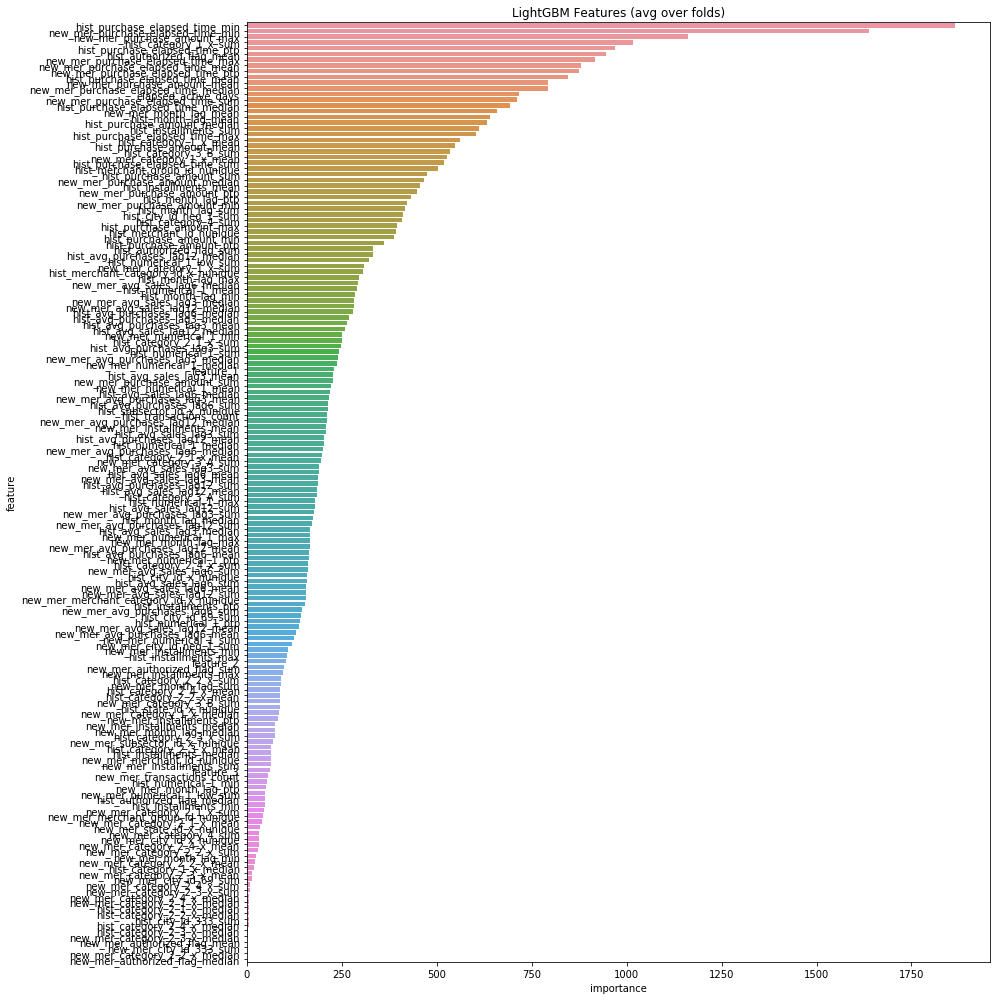

In [124]:
plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [125]:
create_submit_file('lgbm_full_model_pred.csv')
# RMSE of Submitted Kaggle File: 3.71266

## Iterative improvements


Next, we consider top 40 features by feature importance and re-build the model. <br>
We would like to compare the full and reduced model to assess their performance. <br>

In [126]:
top_40_features=ximp.sort_values(by=['importance'],ascending=False).head(30)
xtrain_40_normalized = xtrain_normalized[top_40_features.feature.values]
xtest_40_normalized = xtest_normalized[top_40_features.feature.values]

In [127]:
train_ds = xtrain_40_normalized
train_target = ytrain
test_ds = xtest_40_normalized

In [159]:
xtrain_40_normalized.to_csv(intermediate_data_path+'xtrain_40_normalized_all.csv',index=False)
xtest_40_normalized.to_csv(intermediate_data_path+'xtest_40_normalized_all.csv',index=False)

In [128]:
feature_importance_df = np.zeros((train_ds.shape[1], nfolds))
mvalid = np.zeros(len(train_ds))
mfull = np.zeros(len(test_ds))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_ds.values, train_target.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0,y0 = train_ds.iloc[trn_idx], train_target[trn_idx]
    x1,y1 = train_ds.iloc[val_idx], train_target[val_idx]

    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(test_ds, num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.5871	valid_1's rmse: 3.72368
[1000]	training's rmse: 3.53525	valid_1's rmse: 3.7134
Early stopping, best iteration is:
[1306]	training's rmse: 3.50925	valid_1's rmse: 3.71234
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.59315	valid_1's rmse: 3.66623
Early stopping, best iteration is:
[823]	training's rmse: 3.55568	valid_1's rmse: 3.66227
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.59932	valid_1's rmse: 3.60209
[1000]	training's rmse: 3.54564	valid_1's rmse: 3.59206
[1500]	training's rmse: 3.50544	valid_1's rmse: 3.58964
Early stopping, best iteration is:
[1775]	training's rmse: 3.48373	valid_1's rmse: 3.58875
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.59175	valid_1's rmse: 3.67174
[1000]	training's rmse: 3.53863	va

In [129]:
# Find feature Importance
ximp = pd.DataFrame()
ximp['feature'] = train_ds.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)

display(ximp.sort_values(by=['importance'],ascending=False))

,feature,importance
0,hist_purchase_elapsed_time_min,2432.0
1,new_mer_purchase_elapsed_time_min,2180.9
4,hist_purchase_elapsed_time_ptp,1808.4
2,new_mer_purchase_amount_max,1777.3
3,hist_category_1_x_sum,1709.7
13,new_mer_purchase_elapsed_time_sum,1647.3
16,hist_month_lag_mean,1546.3
5,hist_authorized_flag_mean,1470.0
25,hist_merchant_group_id_nunique,1458.6
18,hist_installments_sum,1419.7


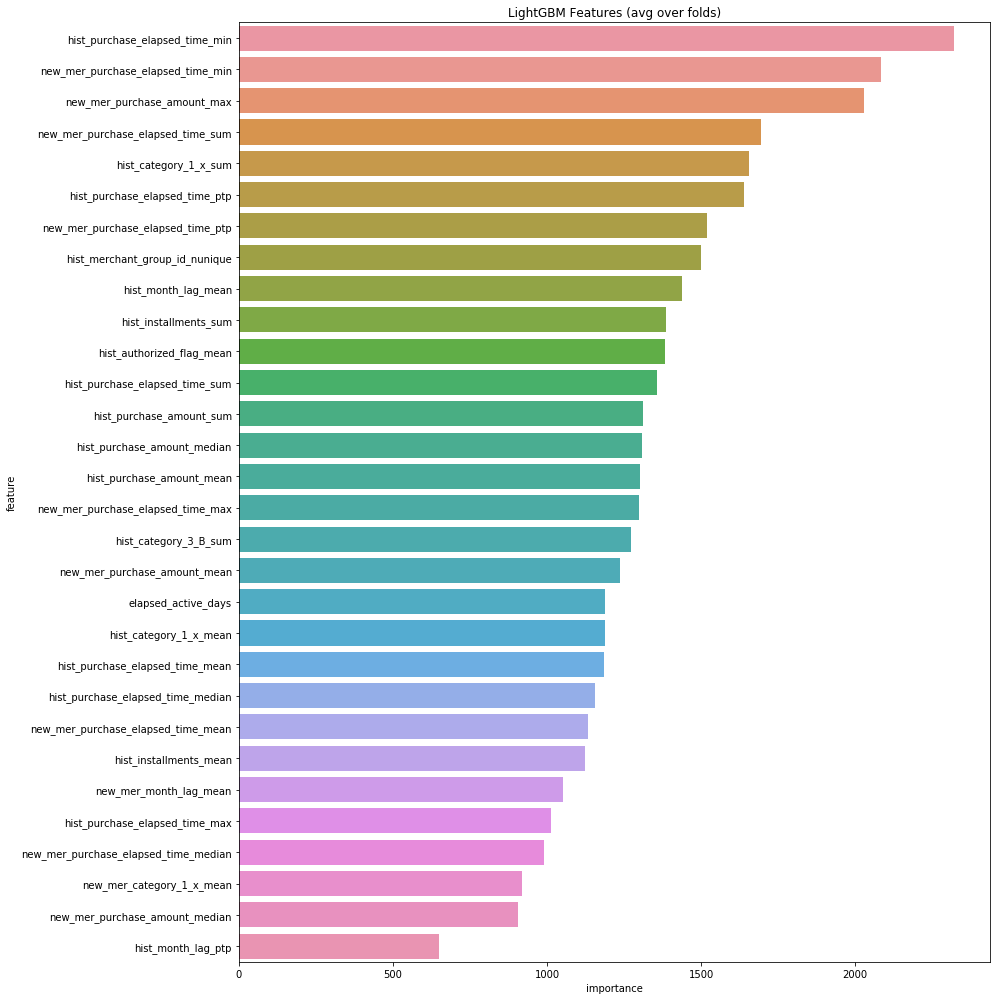

In [97]:
plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [130]:
create_submit_file('lgbm_red_40f_pred.csv.csv')
# RMSE of Submitted Kaggle File: 3.71770

## Ridge Regression


Next, We will try to fit a Ridge Regressor on our problem. Ridge Regression sounds like a good choice because
the algorithm applies a penalty on variables with large values. <br>

As there are many null values in the new merchants aggregated dataset, we will build the ridge regression on a dataset from measures from historical tranactions dataset only. 

In [174]:

train_ds_ridge=train_ds[['hist_purchase_elapsed_time_min', 'hist_category_1_x_sum',
       'hist_purchase_elapsed_time_mean',
       'hist_purchase_elapsed_time_median', 
       'hist_month_lag_mean', 'hist_purchase_amount_median',
       'hist_installments_sum', 'hist_purchase_elapsed_time_max',
       'hist_category_1_x_mean', 'hist_purchase_amount_mean',
       'hist_category_3_B_sum',
       'hist_purchase_elapsed_time_sum', 'hist_merchant_group_id_nunique',
       'hist_purchase_amount_sum',
       'hist_installments_mean']]

In [175]:
test_ds_ridge=test_ds[['hist_purchase_elapsed_time_min', 'hist_category_1_x_sum',
       'hist_purchase_elapsed_time_mean',
       'hist_purchase_elapsed_time_median', 
       'hist_month_lag_mean', 'hist_purchase_amount_median',
       'hist_installments_sum', 'hist_purchase_elapsed_time_max',
       'hist_category_1_x_mean', 'hist_purchase_amount_mean',
       'hist_category_3_B_sum',
       'hist_purchase_elapsed_time_sum', 'hist_merchant_group_id_nunique',
       'hist_purchase_amount_sum',
       'hist_installments_mean']]

In [161]:
display(train_ds.isna().sum())
display(test_ds.isna().sum())

hist_purchase_elapsed_time_min              0
new_mer_purchase_elapsed_time_min       21931
new_mer_purchase_amount_max             21931
hist_category_1_x_sum                       0
hist_purchase_elapsed_time_ptp              0
hist_authorized_flag_mean                   0
new_mer_purchase_elapsed_time_max       21931
new_mer_purchase_elapsed_time_mean      21931
new_mer_purchase_elapsed_time_ptp       21931
hist_purchase_elapsed_time_mean             0
new_mer_purchase_amount_mean            21931
new_mer_purchase_elapsed_time_median    21931
elapsed_active_days                         0
new_mer_purchase_elapsed_time_sum           0
hist_purchase_elapsed_time_median           0
new_mer_month_lag_mean                  21931
hist_month_lag_mean                         0
hist_purchase_amount_median                 0
hist_installments_sum                       0
hist_purchase_elapsed_time_max              0
hist_category_1_x_mean                      0
hist_purchase_amount_mean         

hist_purchase_elapsed_time_min              0
new_mer_purchase_elapsed_time_min       13608
new_mer_purchase_amount_max             13608
hist_category_1_x_sum                       0
hist_purchase_elapsed_time_ptp              0
hist_authorized_flag_mean                   0
new_mer_purchase_elapsed_time_max       13608
new_mer_purchase_elapsed_time_mean      13608
new_mer_purchase_elapsed_time_ptp       13608
hist_purchase_elapsed_time_mean             0
new_mer_purchase_amount_mean            13608
new_mer_purchase_elapsed_time_median    13608
elapsed_active_days                         1
new_mer_purchase_elapsed_time_sum           0
hist_purchase_elapsed_time_median           0
new_mer_month_lag_mean                  13608
hist_month_lag_mean                         0
hist_purchase_amount_median                 0
hist_installments_sum                       0
hist_purchase_elapsed_time_max              0
hist_category_1_x_mean                      0
hist_purchase_amount_mean         

In [165]:
display(train_ds_ridge.isna().sum())
display(test_ds_ridge.isna().sum())

hist_purchase_elapsed_time_min       0
hist_category_1_x_sum                0
hist_purchase_elapsed_time_mean      0
hist_purchase_elapsed_time_median    0
hist_month_lag_mean                  0
hist_purchase_amount_median          0
hist_installments_sum                0
hist_purchase_elapsed_time_max       0
hist_category_1_x_mean               0
hist_purchase_amount_mean            0
hist_category_3_B_sum                0
hist_purchase_elapsed_time_sum       0
hist_merchant_group_id_nunique       0
hist_purchase_amount_sum             0
hist_installments_mean               0
dtype: int64

hist_purchase_elapsed_time_min       0
hist_category_1_x_sum                0
hist_purchase_elapsed_time_mean      0
hist_purchase_elapsed_time_median    0
hist_month_lag_mean                  0
hist_purchase_amount_median          0
hist_installments_sum                0
hist_purchase_elapsed_time_max       0
hist_category_1_x_mean               0
hist_purchase_amount_mean            0
hist_category_3_B_sum                0
hist_purchase_elapsed_time_sum       0
hist_merchant_group_id_nunique       0
hist_purchase_amount_sum             0
hist_installments_mean               0
dtype: int64

In [ ]:
# Find the best value of alpha through cv grid search

In [176]:
clf = Ridge(alpha=1.0)

In [177]:
clf.fit(train_ds_ridge, train_target)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [178]:
y = clf.predict(test_ds_ridge)

In [179]:
create_submit_file('ridge_reg_1.csv', id_test, y)
# RMSE of submitted KAggle File: 3.717

# THE END